In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testdf = pd.read_csv('test.csv')
traindf = pd.read_csv('train.csv')

In [71]:
model_path = 'e=1_itr=68_cancel_june3-1201'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics)

{   'args': {   '--batch-size': '256',
                '--clip-grad': '5.0',
                '--dropout': '0',
                '--dset-size': '0',
                '--embed-size': '512',
                '--help': False,
                '--hidden-size': '512',
                '--load': False,
                '--load-from': 'default-model',
                '--log-every': '10',
                '--lr': '0.0003',
                '--max-epoch': '30',
                '--max-sent-len': '800',
                '--n-heads': '2',
                '--n-layers': '1',
                '--n-valid': '300',
                '--n-words': '10000',
                '--qtest': False,
                '--save': True,
                '--save-to': 'june3-1201',
                '--seed': '0',
                '--valid-niter': '10',
                '--validate-every': '10'},
    'epochs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'total_time': 210.7281,
    'train_acc': [   0.502734375,
                     0.

Total Time: 217.4138 
Train Time: 31.952
Max (Validation, Train): (0.83, 0.91)


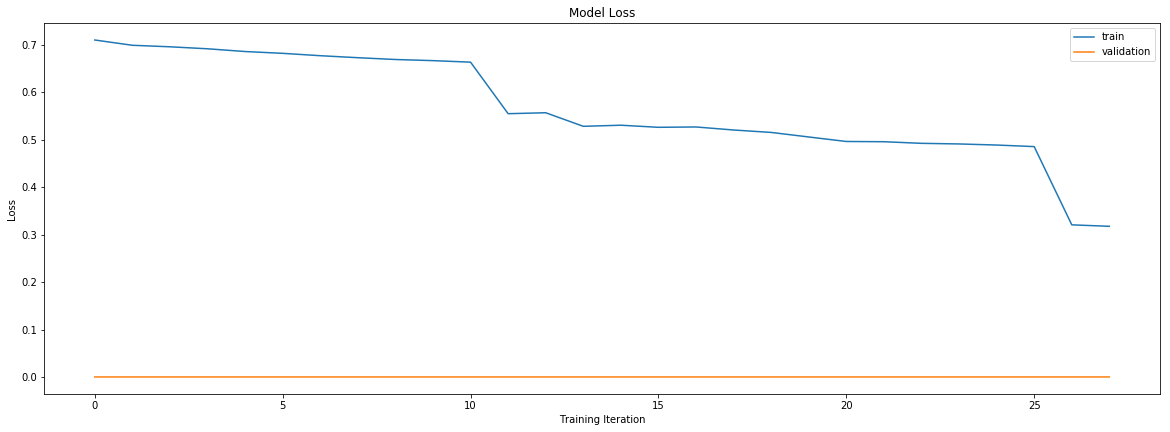

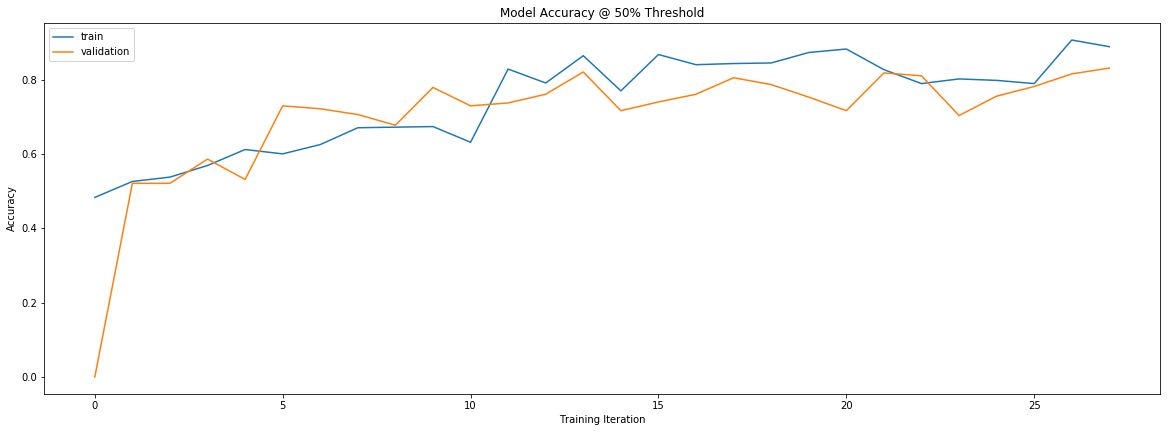

In [20]:
def format_sent(sentence):
    formatted_sentence = ['<start>', '0']
    idxs = list(range(1, len(sentence)+1))
    for (w, i) in list(zip(sentence, idxs)):
        formatted_sentence.append(w)
        formatted_sentence.append(str(i))
    formatted_sentence.append('<end>')
    formatted_sentence.append(str(len(idxs)+1))
    
    return ' '.join(formatted_sentence)

def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    print("Max (Validation, Train): (%.2f, %.2f)" % (max(metrics['val_acc']), max(metrics['train_acc'])))
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    figsize = (20, 15)
    plt.figure(1, figsize=figsize)                
    plt.subplot(211)
    plt.plot(metrics['itr'], metrics['train_loss'],  label='train')
    plt.plot(metrics['val_itr'], metrics['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    # plot accuracy
    plt.figure(2, figsize=figsize)                # a second figure
    plt.subplot(212)
    plt.plot(metrics['itr'], metrics['train_acc'], label='train')
    plt.plot(metrics['val_itr'], metrics['val_acc'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy @ 50% Threshold')
    
    
    plt.show()
    
plot_metrics(metrics)

In [23]:
# Sample Example from dataset
batch_size = 50
df = traindf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

30

In [38]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()
batch_attn = tracked_attention_weigths[0].detach().numpy().squeeze()
i = 0

Predicted Value: 0.32 True Value: 0.00


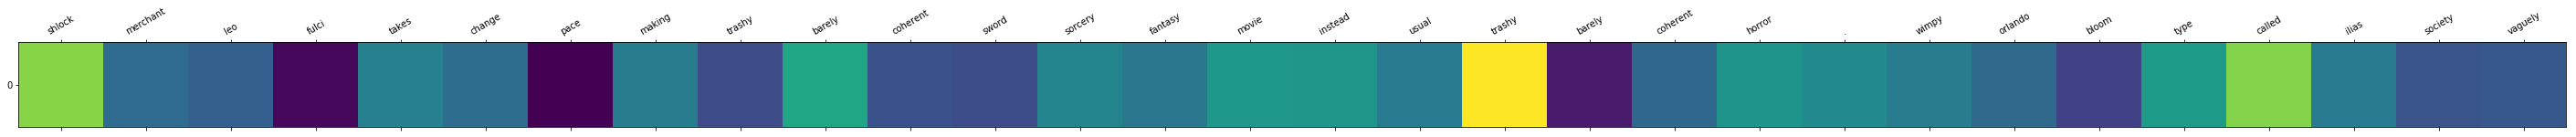

In [41]:
attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')
ax.set_xticklabels([''] + sentence, rotation=30)
# ax.set_yticklabels([''] + sentence)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
i += 1

Predicted Value: 0.68 True Value: 0.00


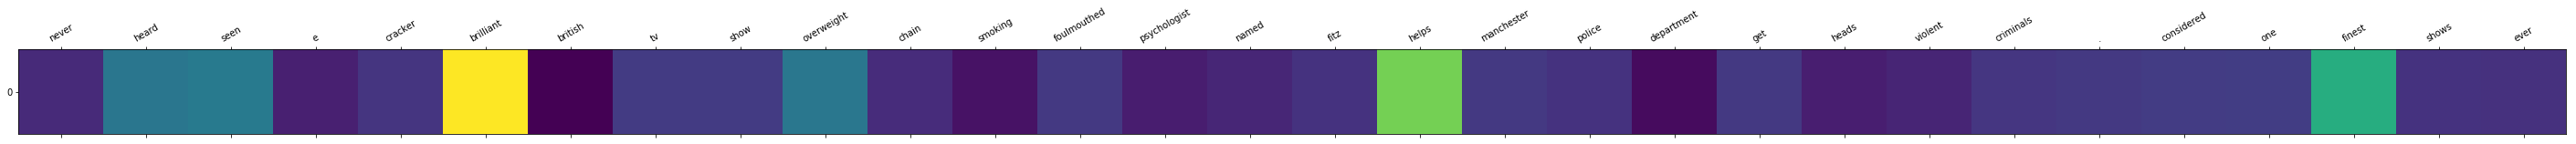

In [43]:
attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')
ax.set_xticklabels([''] + sentence, rotation=30)
# ax.set_yticklabels([''] + sentence)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
i += 1

Predicted Value: 0.31 True Value: 1.00


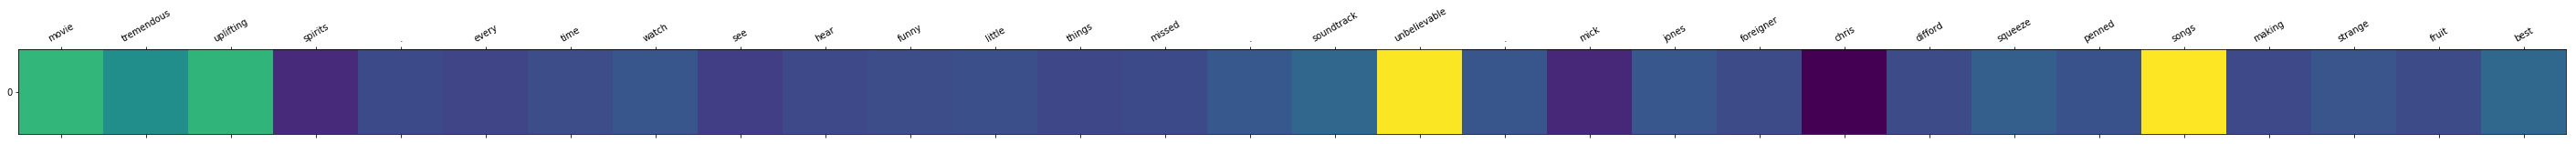

In [49]:
attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')
ax.set_xticklabels([''] + sentence, rotation=30)
# ax.set_yticklabels([''] + sentence)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
i += 1

In [51]:
n_heads =           int(metrics['args']['--n-heads'])
n_layers =          int(metrics['args']['--n-layers'])
embed_size =        int(metrics['args']['--embed-size'])
hidden_size =       int(metrics['args']['--hidden-size'])
max_sentence_len =  int(metrics['args']['--max-sent-len'])
train_batch_size =  int(metrics['args']['--batch-size'])
dropout =  float(metrics['args']['--dropout'])

model = TaskSpecificAttention(lang, device, embed_size, hidden_size, lang.n_words, n_heads, n_layers, dropout, 1)

# Updated Model 

In [83]:
model_path = '3june-2021'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics)

{   'args': {   '--batch-size': '128',
                '--clip-grad': '5.0',
                '--dropout': '0.3',
                '--dset-size': '0',
                '--embed-size': '1028',
                '--help': False,
                '--hidden-size': '256',
                '--load': False,
                '--load-from': 'default-model',
                '--log-every': '10',
                '--lr': '0.0002',
                '--max-epoch': '30',
                '--max-sent-len': '800',
                '--n-heads': '2',
                '--n-layers': '2',
                '--n-valid': '200',
                '--n-words': '10000',
                '--qtest': False,
                '--save': True,
                '--save-to': '3june-2021',
                '--seed': '21',
                '--valid-niter': '10',
                '--validate-every': '10'},
    'epochs': [   0,
                  0,
                  0,
                  0,
                  0,
                  0,
                

Total Time: 463.5723 
Train Time: 53.7502


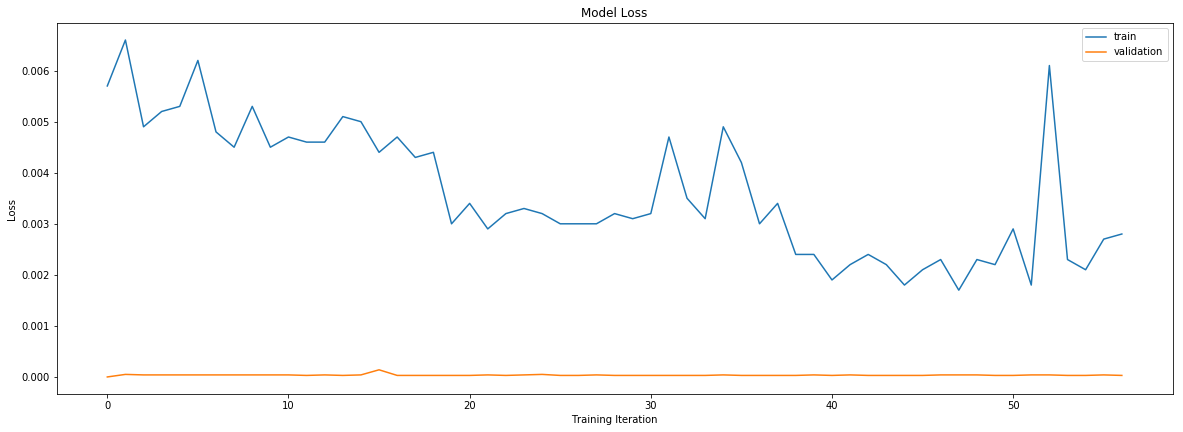

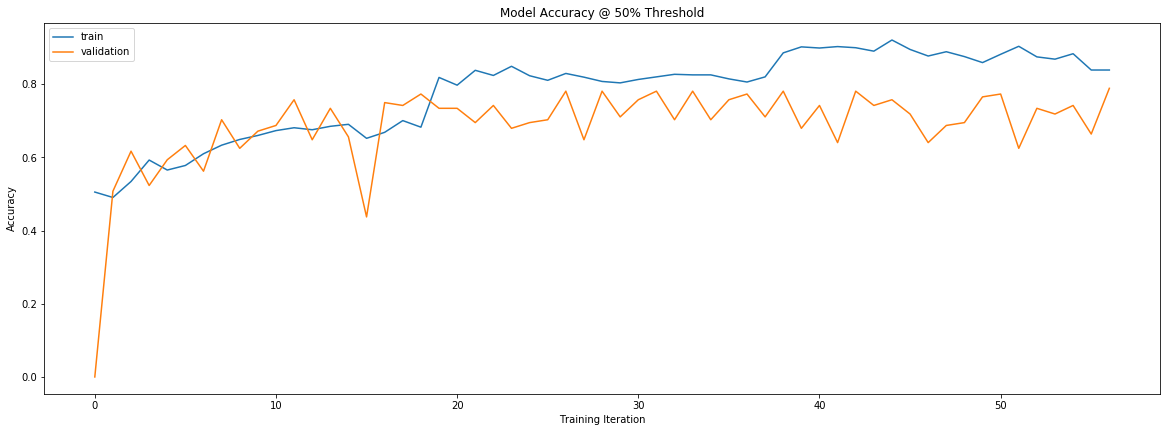

In [84]:
plot_metrics(metrics)

In [141]:
# Sample Example from dataset
batch_size = 50
df = testdf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

40

In [142]:
model._modules.get('attention')

TaskAttention()

In [143]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()

In [144]:
attn_w = 0
batch_attn = tracked_attention_weigths[attn_w].detach().numpy().squeeze()
i = 0

Predicted Value: 0.84 True Value: 1.00
Weights: 1.07314932346344, 0.7005972862243652


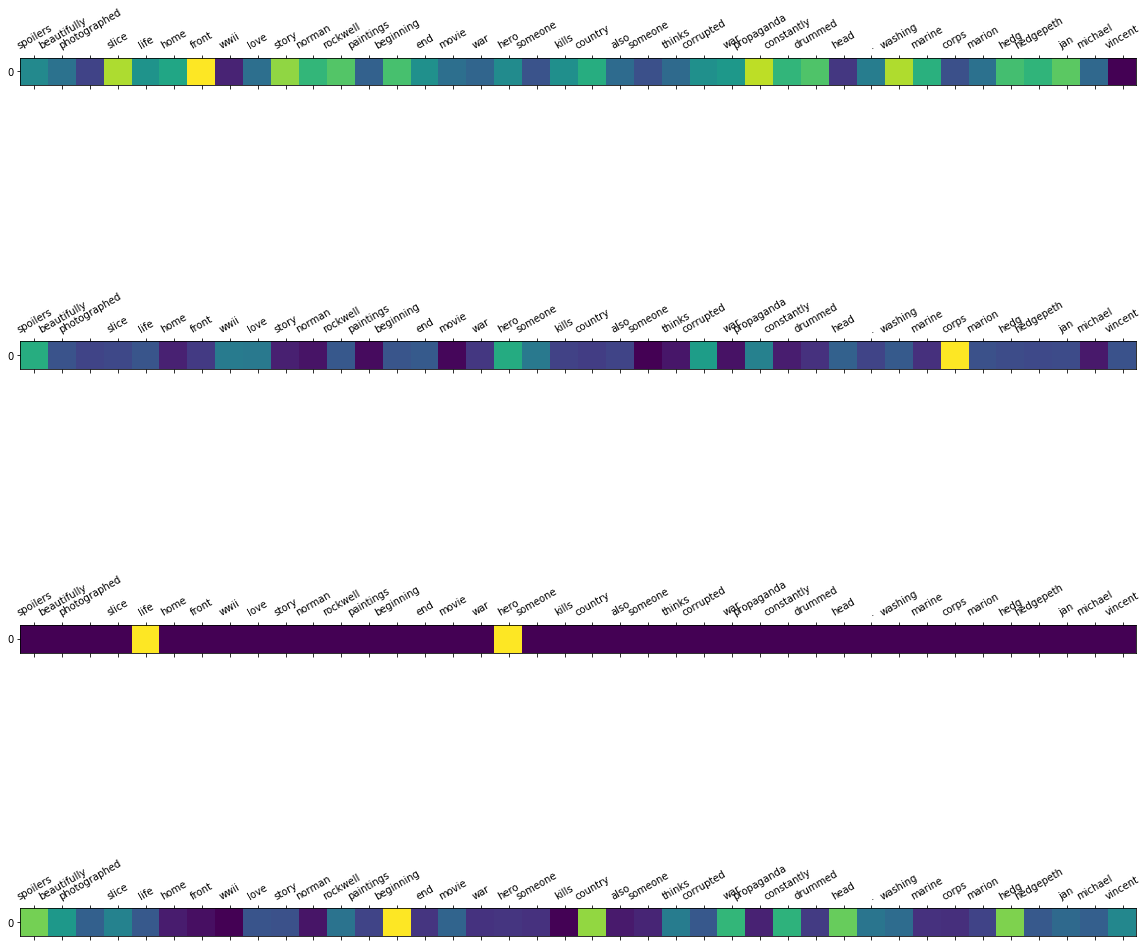

In [145]:
# attn = batch_attn[i][np.newaxis, ...]

sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(20, 20))

for ax, attn in zip(axs.flatten(), tracked_attention_weigths):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Predicted Value: 0.90 True Value: 1.00
Weights: 1.07314932346344, 0.7005972862243652


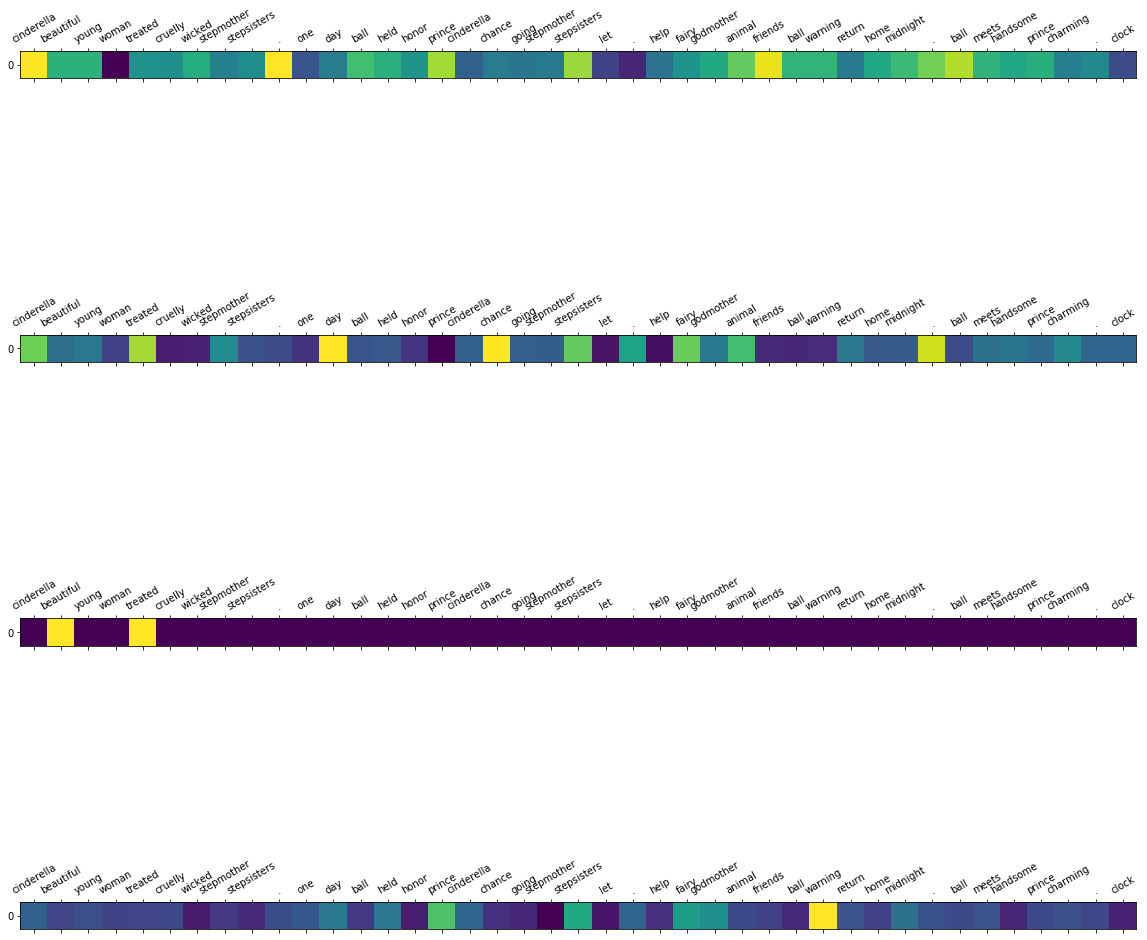

In [131]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(20, 20))

for ax, attn in zip(axs.flatten(), tracked_attention_weigths):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Predicted Value: 0.08 True Value: 0.00
Weights: 1.07314932346344, 0.7005972862243652


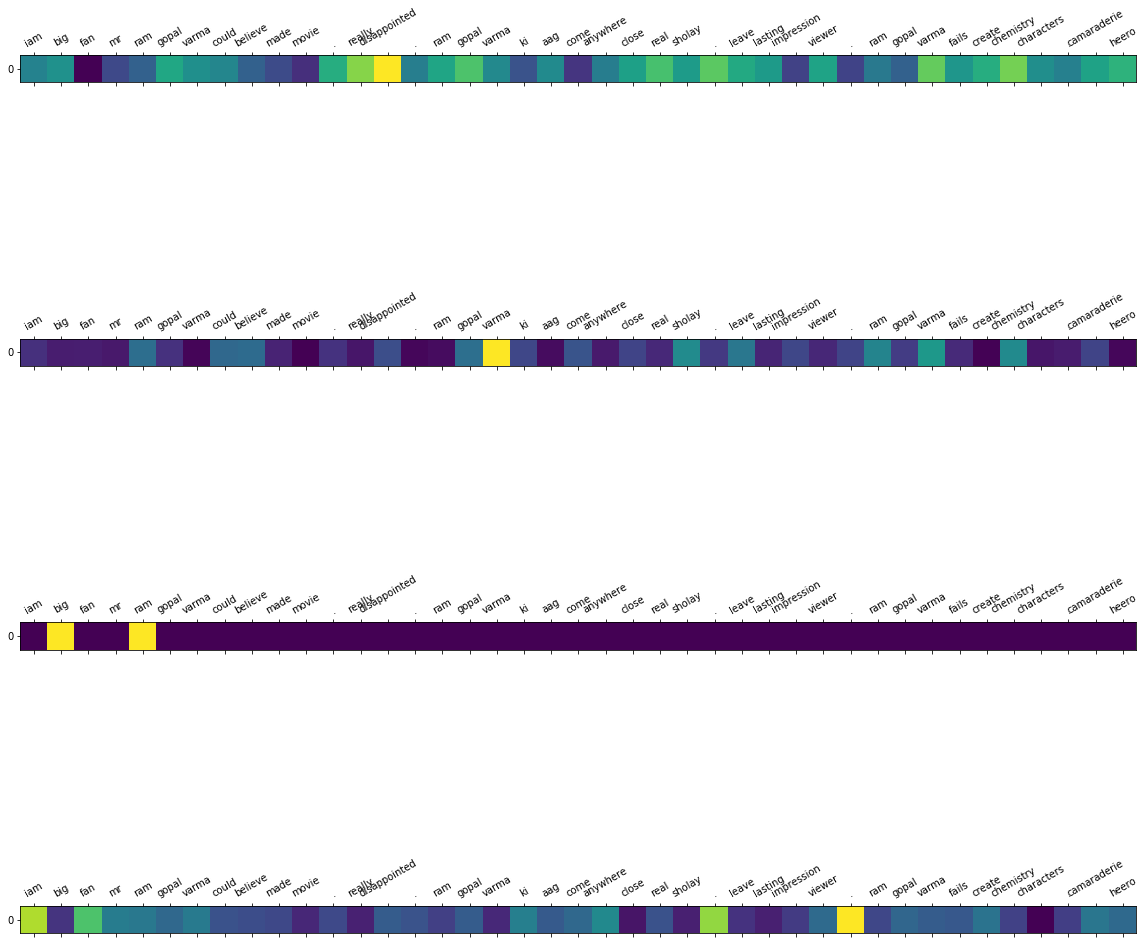

In [132]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(20, 20))

for ax, attn in zip(axs.flatten(), tracked_attention_weigths):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Predicted Value: 0.80 True Value: 1.00
Weights: 1.07314932346344, 0.7005972862243652


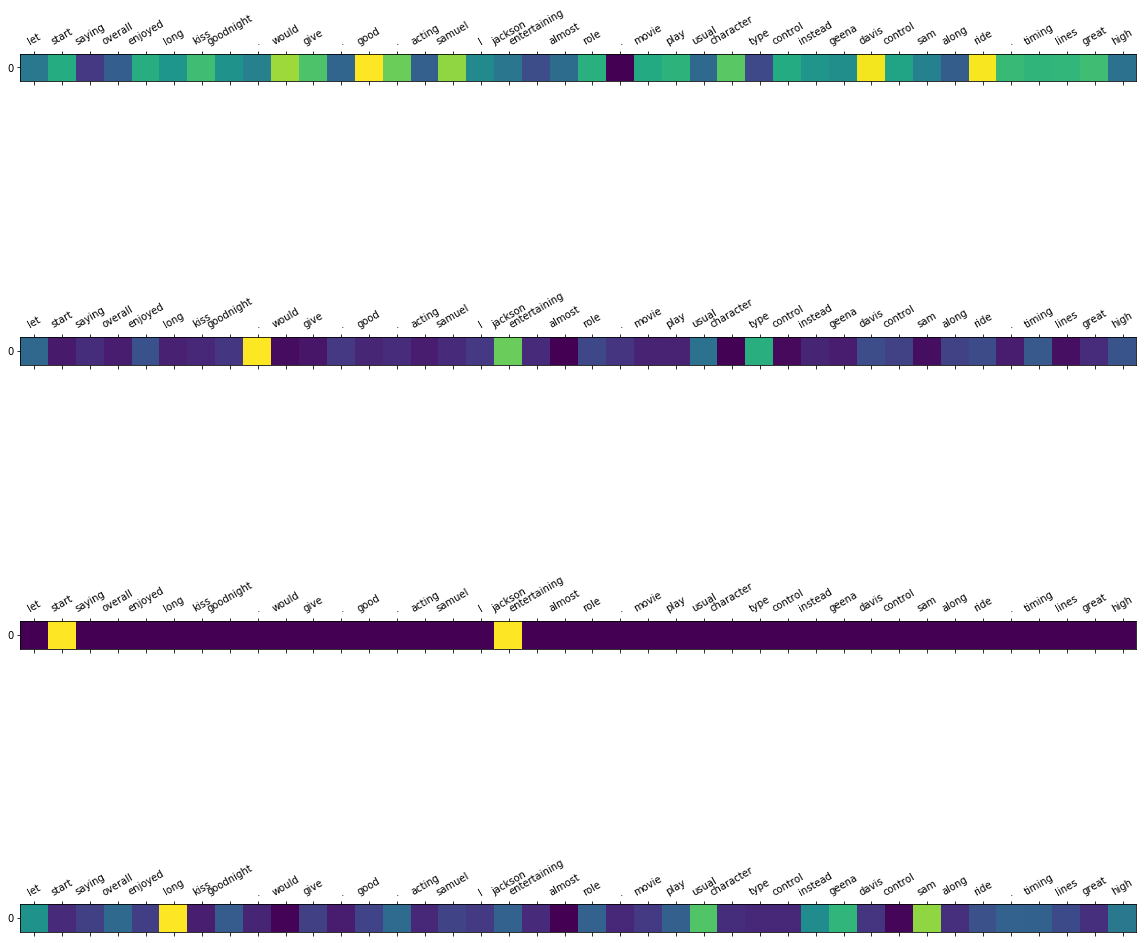

In [155]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(20, 20))

for ax, attn in zip(axs.flatten(), tracked_attention_weigths):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

# Improved Batch Iterator For Longer Lengths

In [23]:
model_path = 'june3-2324'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics['args'])

In [ ]:
plot_metrics(metrics)

In [7]:
# Sample Example from dataset
batch_size = 50
df = testdf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

130

In [8]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()

In [9]:
i = 0

Hypothesis: 
The Attention is used with a negative weight so that when the values are put through the RelU their values are forgotten. Forget what is not important. Anti-Attention.

Least Attent Words:
----------Attention 0-----------
ed: 0.011809524148702621
hardy: 0.011820914223790169
us: 0.011826841160655022
course: 0.011829638853669167
last: 0.011829892173409462
----------Attention 1-----------
hilarious: 0.001803358900360763
good: 0.0018360837129876018
.: 0.0022815167903900146
present: 0.00240509444847703
goat: 0.0024694709572941065
----------Attention 2-----------
love: 0.00600220263004303
however: 0.0068870116956532
still: 0.006909131072461605
stan: 0.0069573381915688515
left: 0.006967389024794102
----------Attention 3-----------
team: 0.0017058536177501082
hilarious: 0.0017520346445962787
however: 0.002231813967227936
!: 0.002417788142338395
wood: 0.002532819053158164

Predicted Value: 0.58 True Value: 1.00
Weights: -1.3753557205200195, -1.3247740268707275


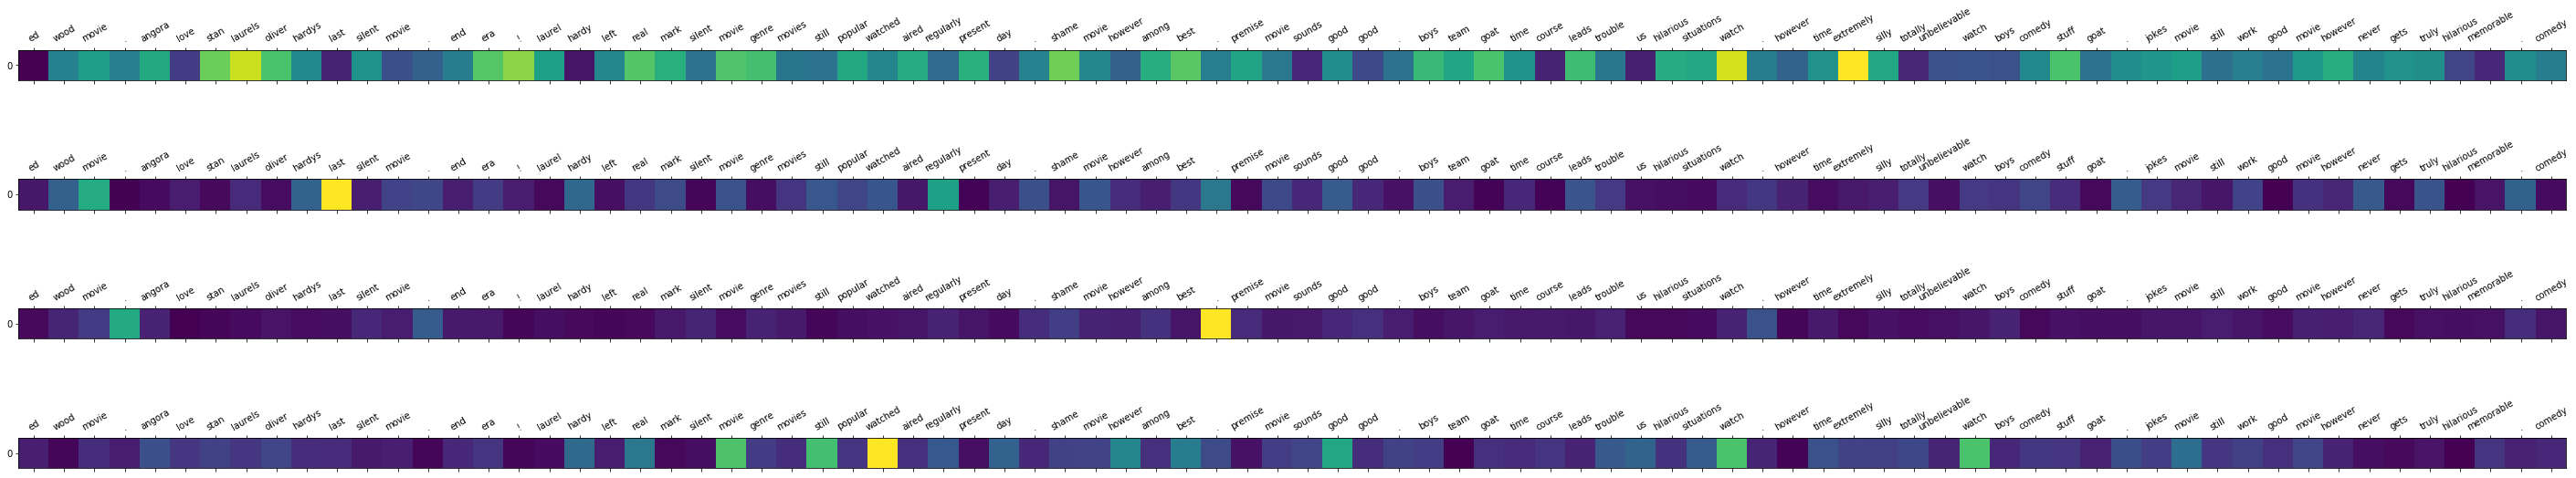

In [230]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Least Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Least Attent Words:
----------Attention 0-----------
flat: 0.011771883815526962
generous: 0.011815741658210754
sexually: 0.011818491853773594
cars: 0.011831436306238174
done: 0.011834470555186272
----------Attention 1-----------
well: 0.0013958116760477424
inconsistent: 0.0016572767635807395
premise: 0.0016828292282298207
acted: 0.0019700247794389725
women: 0.002347031142562628
----------Attention 2-----------
young: 0.0057077473029494286
ex: 0.00578097440302372
poor: 0.007270663511008024
satisfied: 0.007550198584794998
asthma: 0.00806159246712923
----------Attention 3-----------
cardboard: 0.0012030369834974408
two: 0.0020515359938144684
want: 0.002061296021565795
woman: 0.0024467927869409323
get: 0.002476456807926297

Predicted Value: 0.32 True Value: 0.00
Weights: -1.3753557205200195, -1.3247740268707275


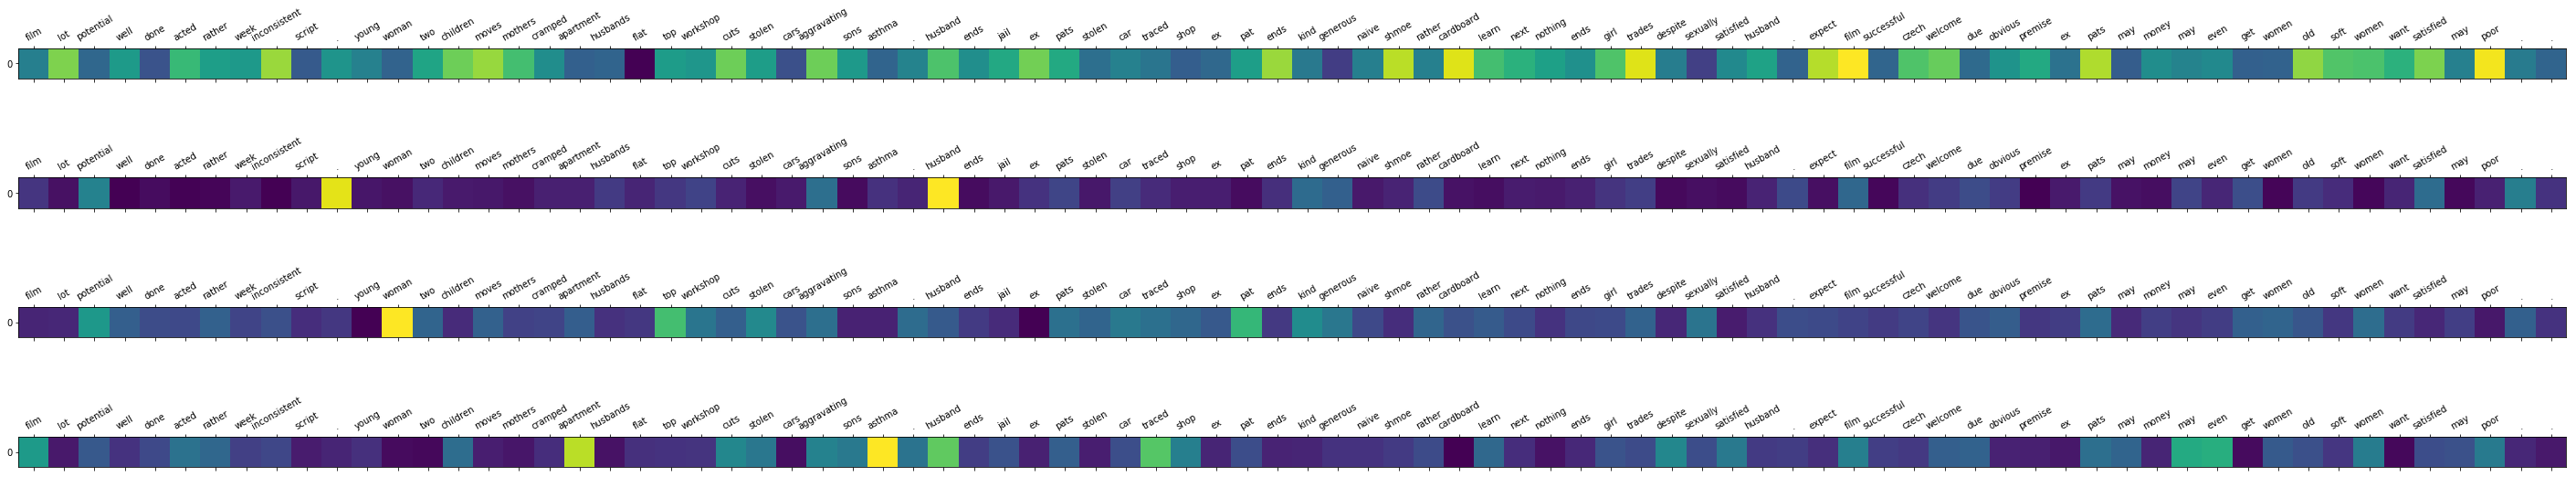

In [235]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
weight = model.weight1 if attn_w % 2 == 0 else model.weight2
weight = model.weight1.detach().numpy().squeeze()


fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Least Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Least Attent Words:
----------Attention 0-----------
miranda: 0.007627841550856829
character: 0.007631281856447458
show: 0.007639608345925808
let: 0.007646238896995783
!: 0.007646520156413317
----------Attention 1-----------
miranda: 0.007627841550856829
character: 0.007631281856447458
show: 0.007639608345925808
let: 0.007646238896995783
!: 0.007646520156413317
----------Attention 2-----------
think: 0.0003344171855133027
davis: 0.0005517462850548327
anything: 0.000654009054414928
along: 0.0007246231543831527
try: 0.0010671538766473532
----------Attention 3-----------
think: 0.0003344171855133027
davis: 0.0005517462850548327
anything: 0.000654009054414928
along: 0.0007246231543831527
try: 0.0010671538766473532
----------Attention 4-----------
woman: 0.005034823901951313
idiot: 0.005059556104242802
!: 0.005300992168486118
genitals: 0.005305377766489983
friend: 0.00550268916413188
----------Attention 5-----------
woman: 0.005034823901951313
idiot: 0.005059556104242802
!: 0.00530099216848

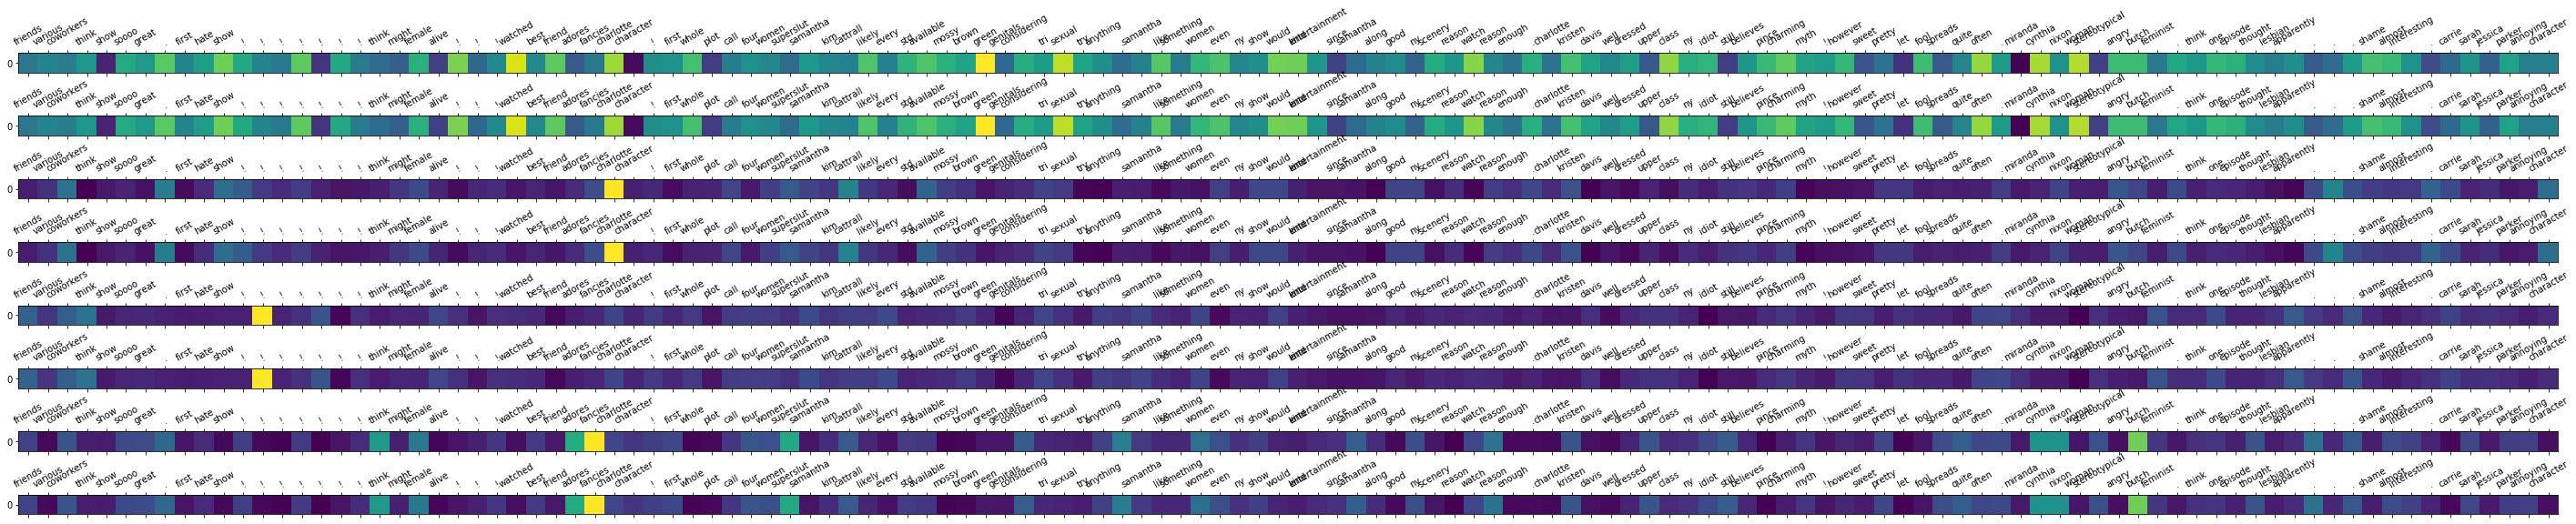

In [12]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]
n = 5

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Least Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

# Glove Embeddings

In [15]:
model_path = '4june-1145-trainable-glove'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics['args'])

{   '--batch-size': '128',
    '--clip-grad': '5.0',
    '--dropout': '0.3',
    '--dset-size': '0',
    '--embed-size': '300',
    '--help': False,
    '--hidden-size': '1024',
    '--load': False,
    '--load-from': 'default-model',
    '--log-every': '10',
    '--lr': '0.0002',
    '--max-epoch': '30',
    '--max-sent-len': '800',
    '--n-heads': '2',
    '--n-layers': '2',
    '--n-valid': '200',
    '--n-words': '10000',
    '--qtest': False,
    '--save': True,
    '--save-to': '4june-1145-trainable-glove',
    '--seed': '21',
    '--valid-niter': '10',
    '--validate-every': '10'}


Total Time: 217.4138 
Train Time: 31.952
Max (Validation, Train): (0.83, 0.91)


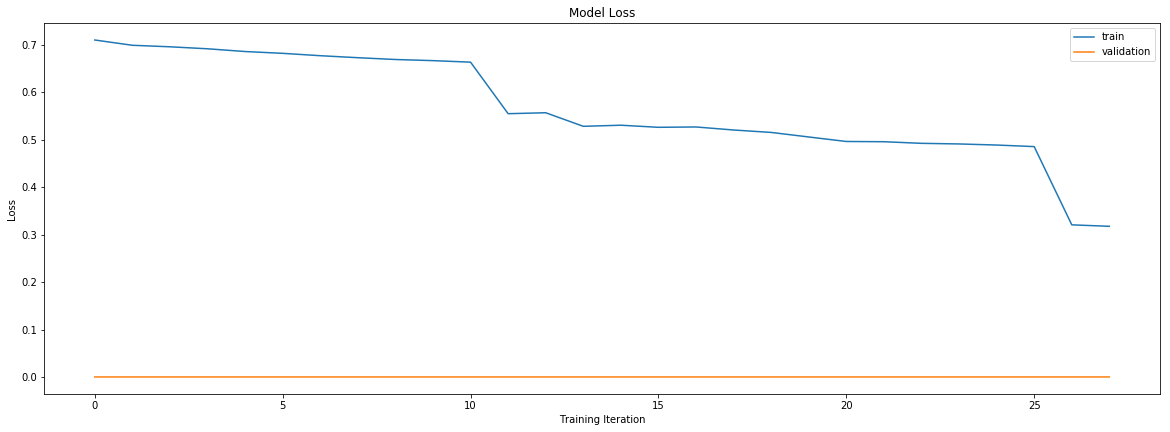

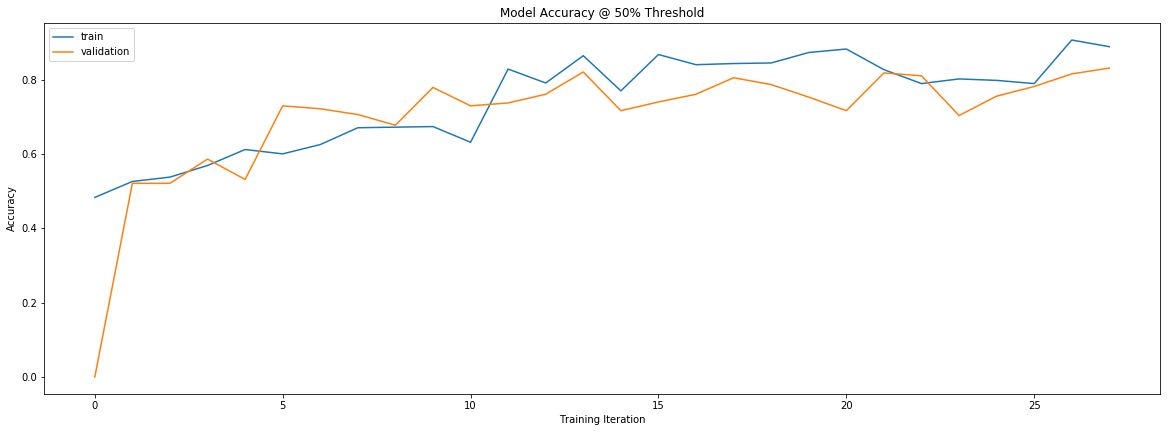

In [21]:
plot_metrics(metrics)

In [24]:
# Sample Example from dataset
batch_size = 50
df = testdf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(list(map(len, sents)))

61

In [25]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()

In [26]:
i = 0

Most Attent Words:
----------Attention 0-----------
.: 0.016680100932717323
level: 0.01655920408666134
fred: 0.016556793823838234
.: 0.016556108370423317
score: 0.016553794965147972
----------Attention 1-----------
.: 0.05078122392296791
cast: 0.0456235371530056
.: 0.04373195767402649
morris: 0.03778674453496933
components: 0.034347668290138245
----------Attention 2-----------
film: 0.6623974442481995
loved: 0.08666175603866577
kept: 0.07993338257074356
looks: 0.056075770407915115
awesome: 0.023844948038458824
----------Attention 3-----------
loved: 0.05560741573572159
film: 0.049064941704273224
newmans: 0.04547585919499397
watching: 0.03434765711426735
potential: 0.032676808536052704

Predicted Value: 0.90 True Value: 1.00
Weights: 1.453977346420288, -1.4640002250671387


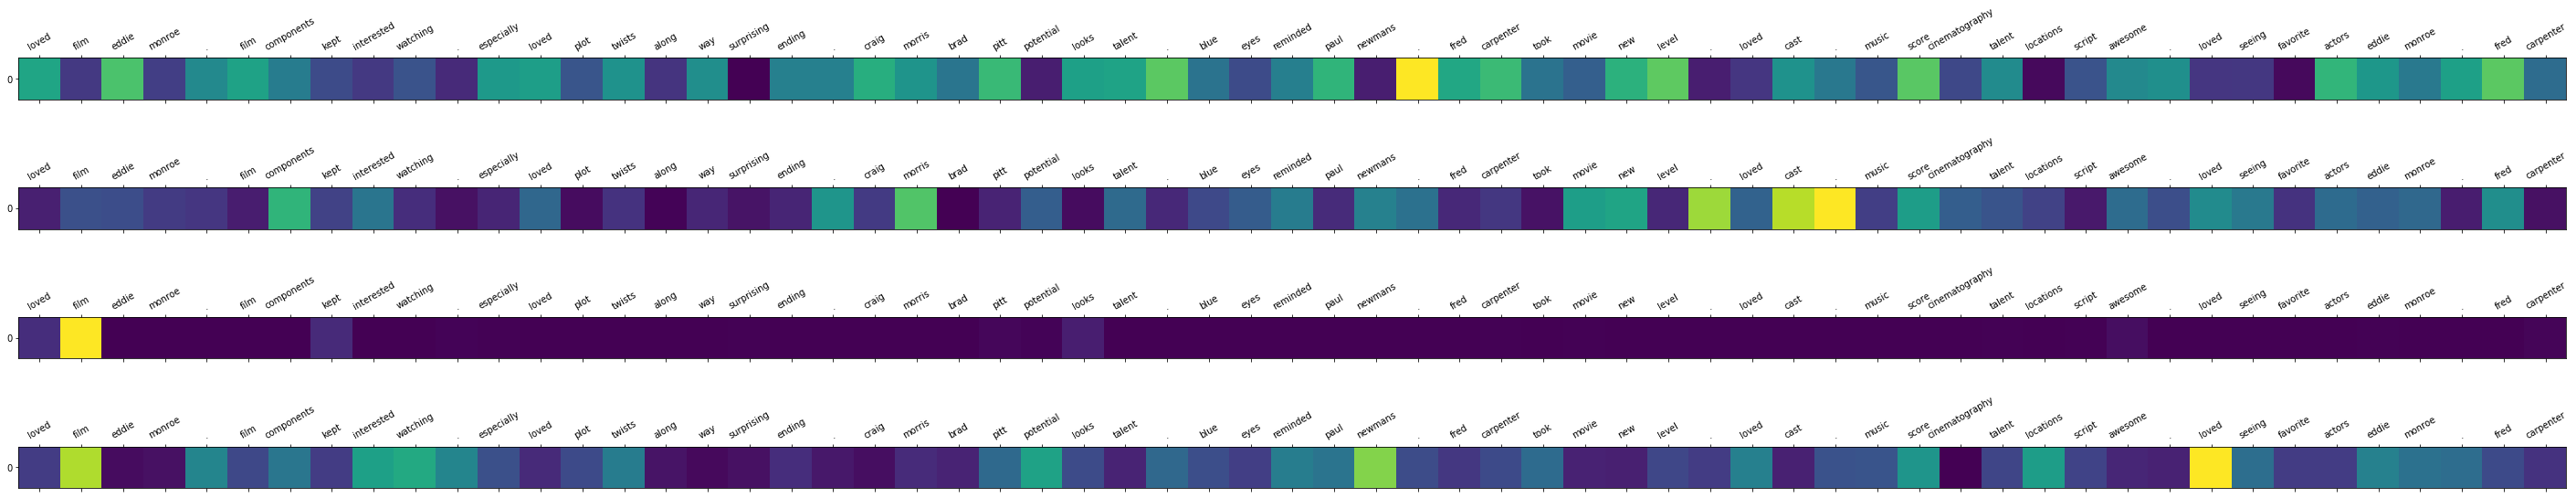

In [32]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Most Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (-attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
.: 0.01660594344139099
.: 0.016552187502384186
held: 0.01654134877026081
funny: 0.016536643728613853
fine: 0.016534505411982536
----------Attention 1-----------
find: 0.03686631843447685
.: 0.036309923976659775
watch: 0.03447136655449867
stay: 0.03398447483778
eyes: 0.03370944410562515
----------Attention 2-----------
great: 0.8846935033798218
good: 0.0502345897257328
film: 0.018771762028336525
notch: 0.013267738744616508
.: 0.004197260830551386
----------Attention 3-----------
great: 0.07596885412931442
miller: 0.04862898960709572
fine: 0.040981702506542206
eyes: 0.03135541081428528
flawless: 0.02757948450744152

Predicted Value: 0.91 True Value: 1.00
Weights: 1.453977346420288, -1.4640002250671387


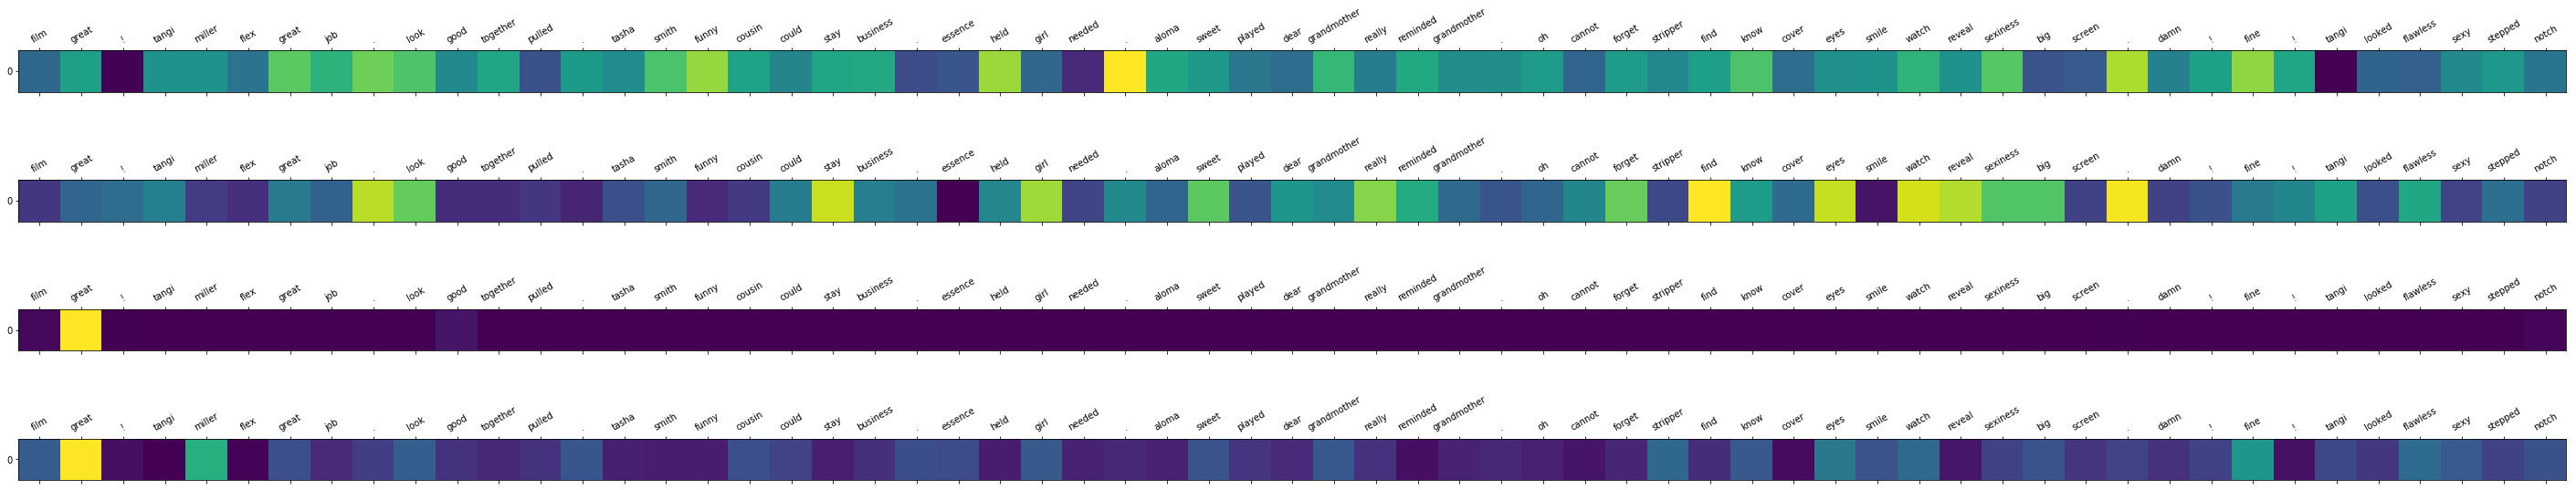

In [38]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Most Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (-attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
flaw: 0.016582516953349113
give: 0.016525965183973312
disprove: 0.01652419939637184
barely: 0.01651138626039028
force: 0.0165073424577713
----------Attention 1-----------
every: 0.04972156882286072
family: 0.03766700625419617
.: 0.029474282637238503
ghost: 0.028944769874215126
involves: 0.02765635959804058
----------Attention 2-----------
paranormal: 0.6050318479537964
fan: 0.10409046709537506
try: 0.04445870220661163
try: 0.03928779810667038
find: 0.02181118167936802
----------Attention 3-----------
give: 0.06214844435453415
piece: 0.04831868037581444
cannot: 0.03526365011930466
every: 0.03392528370022774
voice: 0.03153303265571594

Predicted Value: 0.40 True Value: 0.00
Weights: 1.453977346420288, -1.4640002250671387


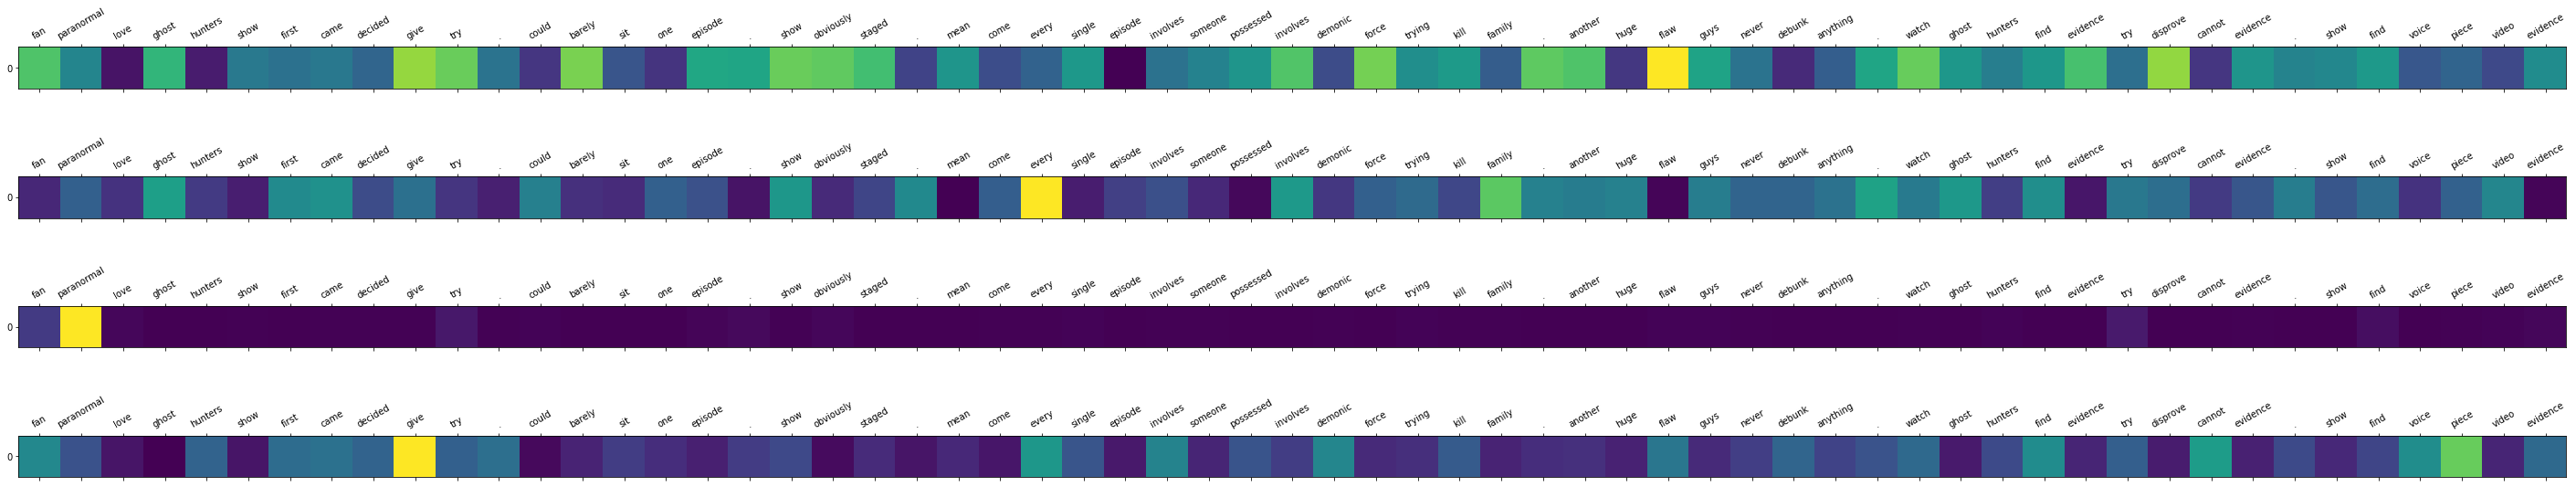

In [39]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

print("Most Attent Words:")
for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    idx = (-attn).argsort()[:n]
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

# Word Embedding Attention

In [75]:
model_path = '4june1300-wordembattn'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics['args'])

{   '--batch-size': '128',
    '--clip-grad': '5.0',
    '--dropout': '0.3',
    '--dset-size': '0',
    '--embed-size': '300',
    '--help': False,
    '--hidden-size': '1024',
    '--load': False,
    '--load-from': 'default-model',
    '--log-every': '10',
    '--lr': '0.0002',
    '--max-epoch': '30',
    '--max-sent-len': '800',
    '--n-heads': '2',
    '--n-layers': '2',
    '--n-valid': '200',
    '--n-words': '10000',
    '--qtest': False,
    '--save': True,
    '--save-to': '4june1301-wordembattn',
    '--seed': '21',
    '--valid-niter': '10',
    '--validate-every': '10'}


Total Time: 254.5514 
Train Time: 37.9161
Max (Validation, Train): (0.80, 0.87)


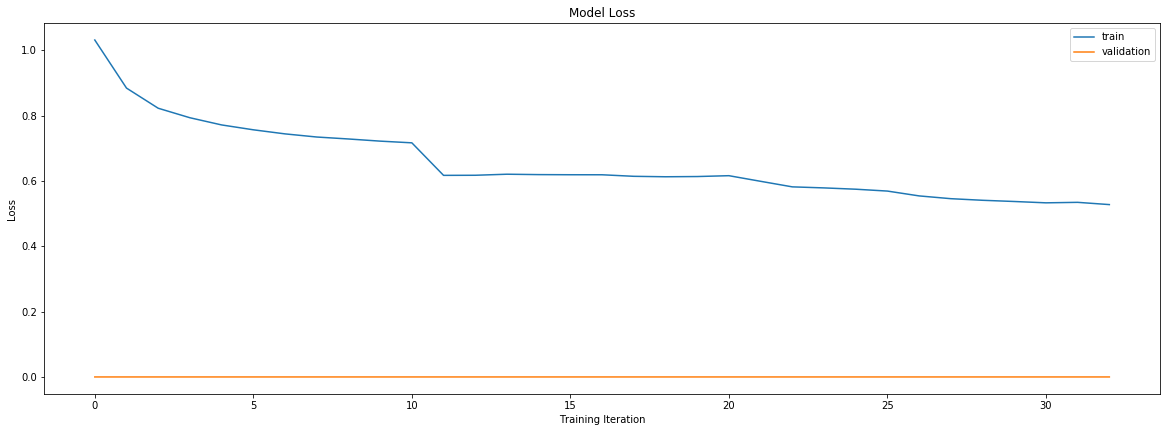

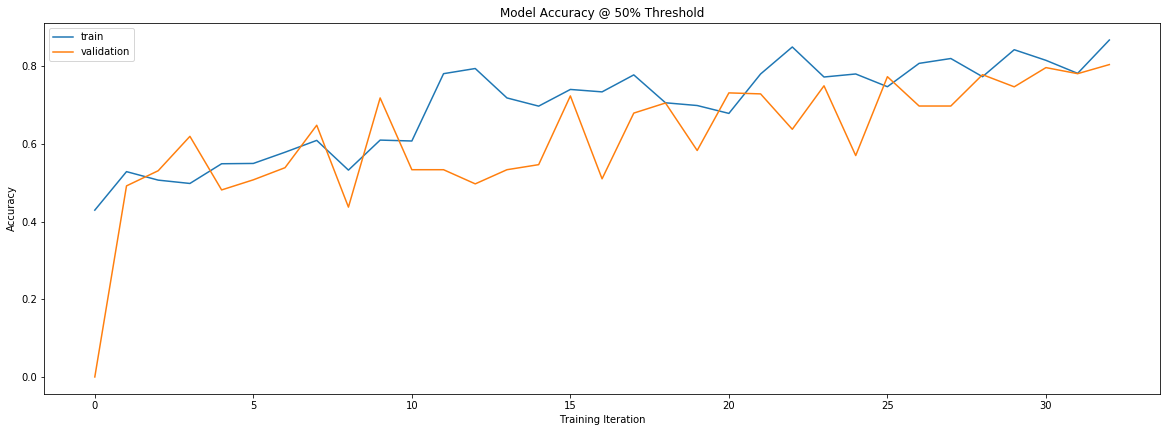

In [52]:
plot_metrics(metrics)

In [53]:
# Sample Example from dataset
batch_size = 50
df = testdf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

60

In [54]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()

In [56]:
i = 0

Least Attent Words:
----------Attention 0-----------
could: 0.015770766884088516
made: 0.016220061108469963
acting: 0.016270430758595467
movie: 0.016340171918272972
movie: 0.016340171918272972

Most Attent Words:
----------Attention 1-----------
lessons: 0.01691247709095478
acting: 0.016888516023755074
martial: 0.016876010224223137
one: 0.016844237223267555
one: 0.016844237223267555

Least Attent Words:
----------Attention 2-----------
ninjutsu: 0.01590813882648945
dickey: 0.01590813882648945
lucinda: 0.01590813882648945
gaijin: 0.01590813882648945
verify: 0.01590813882648945

Most Attent Words:
----------Attention 3-----------
acting: 0.017432574182748795
movie: 0.017001541331410408
movie: 0.017001541331410408
could: 0.016955552622675896
watching: 0.016948828473687172


Predicted Value: 0.70 True Value: 1.00
Weights: -0.7139147520065308, 0.5090352296829224


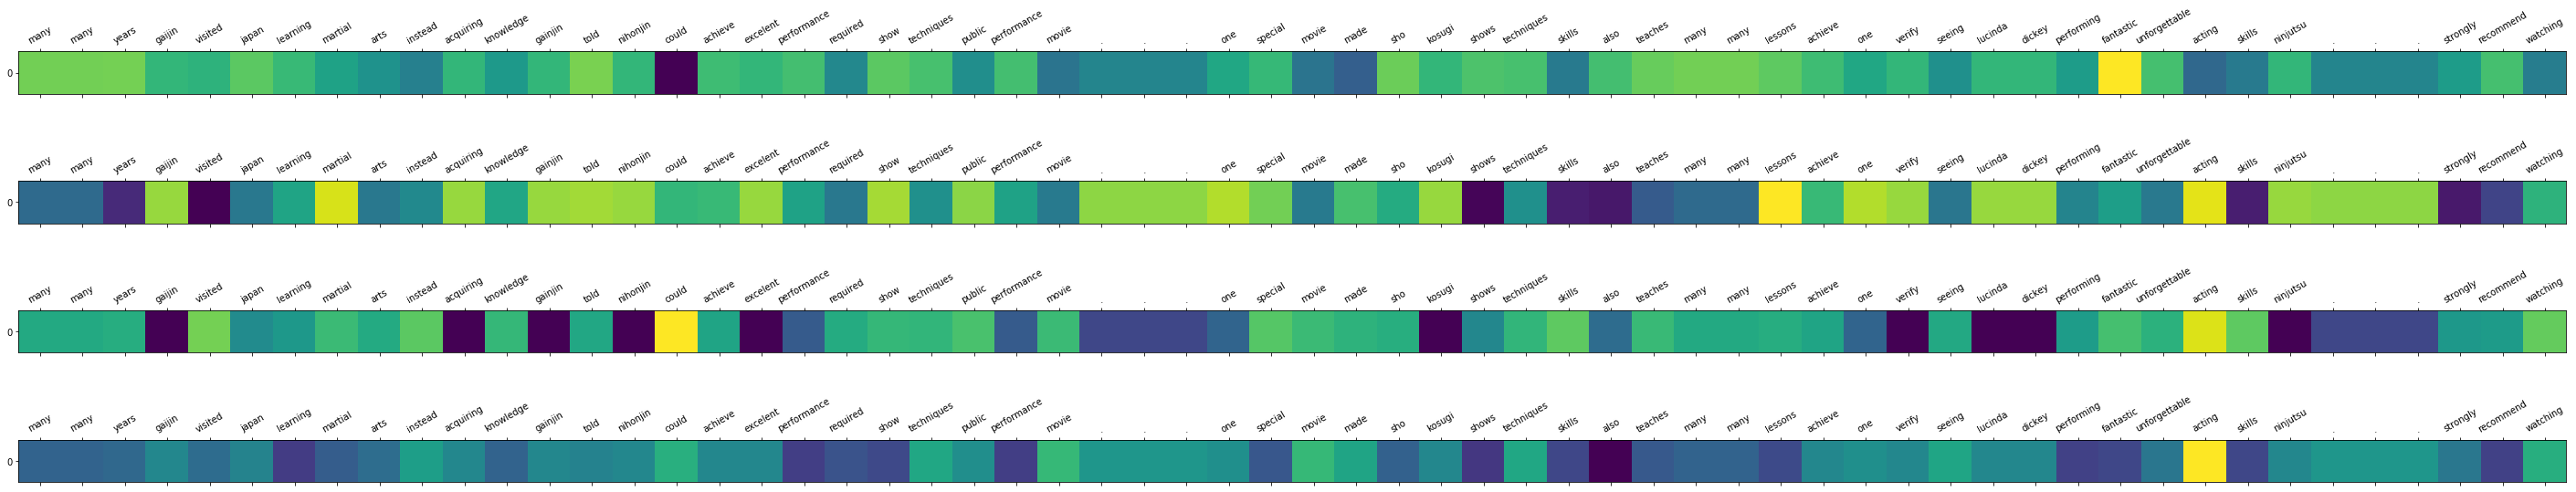

In [74]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 1:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

# Freeze Word Emb. and Learn Task Emb

{   '--batch-size': '128',
    '--clip-grad': '5.0',
    '--dropout': '0.3',
    '--dset-size': '0',
    '--embed-size': '300',
    '--help': False,
    '--hidden-size': '1024',
    '--load': False,
    '--load-from': 'default-model',
    '--log-every': '10',
    '--lr': '0.0002',
    '--max-epoch': '30',
    '--max-sent-len': '800',
    '--n-heads': '2',
    '--n-layers': '2',
    '--n-valid': '200',
    '--n-words': '10000',
    '--qtest': False,
    '--save': True,
    '--save-to': '4june1301-wordembattn',
    '--seed': '21',
    '--valid-niter': '10',
    '--validate-every': '10'}
Total Time: 255.6614 
Train Time: 39.0408
Max (Validation, Train): (0.83, 0.90)


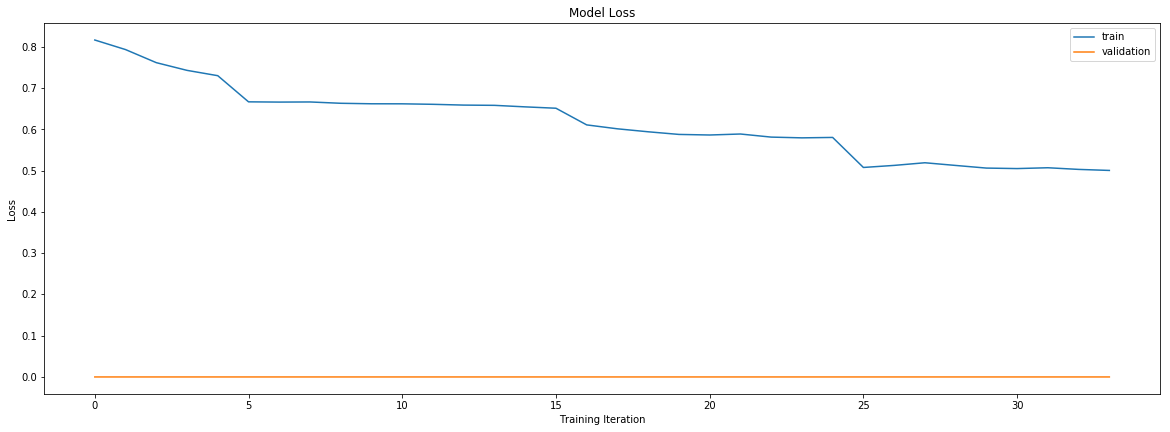

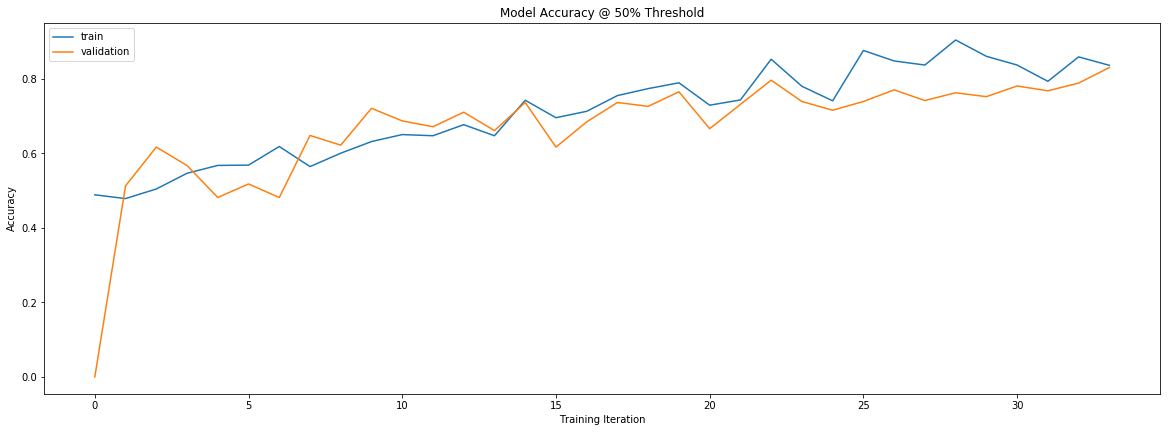

In [76]:
model_path = '4june1301-wordembattn'
model, optim, lang, metrics = load(model_path, cpu=True)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics['args'])
plot_metrics(metrics)

In [89]:
# Sample Example from dataset
batch_size = 50
df = traindf
max_sentence_len = 800
for sents, targets in batch_iter(lang, df, batch_size, max_sentence_len, shuffle=True):
    break
max(map(len, sents))

26

In [92]:
attentions = model._modules.get('attention')
tracked_attention_weigths = []
def show(m, i, o): 
    w = o
    tracked_attention_weigths.append(w)
hook = attentions.register_forward_hook(show)

pred_y = model(sents)
hook.remove()

In [93]:
i = 0

Most Attent Words:
----------Attention 0-----------
belgian: 0.016105124726891518
timecop: 0.016105124726891518
good: 0.016061602160334587
best: 0.015834253281354904
best: 0.015834253281354904

Least Attent Words:
----------Attention 1-----------
john: 0.015082786791026592
personally: 0.015116310678422451
back: 0.015138281509280205
makes: 0.015164753422141075
movies: 0.015184784308075905

Most Attent Words:
----------Attention 2-----------
bad: 0.017074525356292725
save: 0.01591050624847412
okay: 0.015880336984992027
dialogue: 0.015819594264030457
directors: 0.015724189579486847

Least Attent Words:
----------Attention 3-----------
story: 0.014942189678549767
directors: 0.015013929456472397
quite: 0.015096079558134079
movie: 0.015141536481678486
movies: 0.015186052769422531


Predicted Value: 0.58 True Value: 1.00
Weights: 0.9818976521492004, -1.6430469751358032


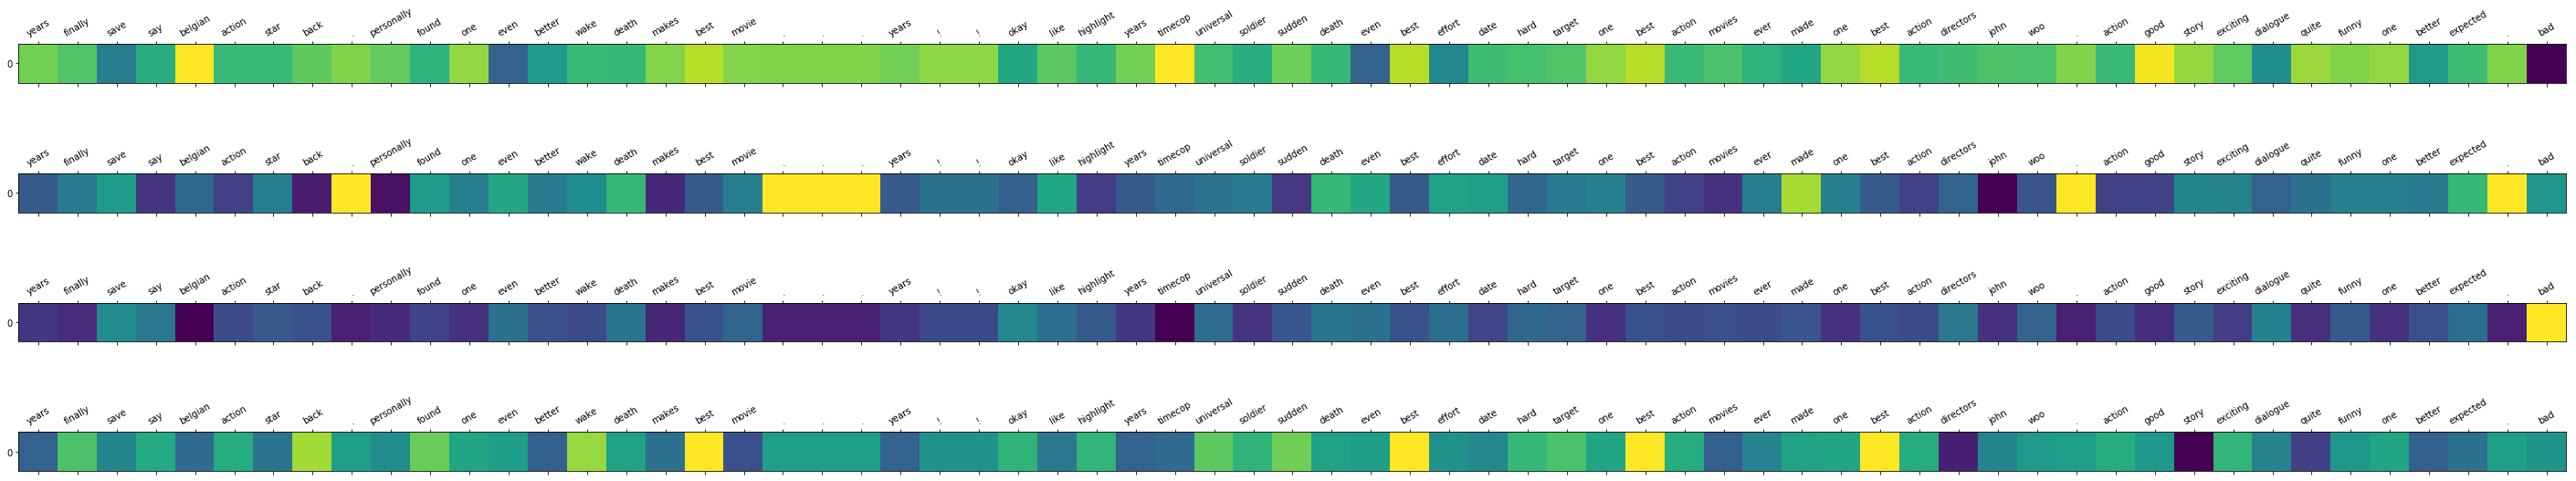

In [85]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels([''] + sentence, rotation=30)
    # ax.set_yticklabels([''] + sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

## Short Term Attention Is Great, Long Term Not So Much 
Longer Sequence => BottleNecks the Softmax Layer? 

Most Attent Words:
----------Attention 0-----------
film: 0.039831001311540604
think: 0.039107948541641235
movie: 0.03896169364452362
.: 0.03894524276256561
.: 0.03894524276256561

Least Attent Words:
----------Attention 1-----------
great: 0.0366055928170681
excellent: 0.037339694797992706
nothing: 0.03746645897626877
family: 0.03747336566448212
perfect: 0.037791065871715546

Most Attent Words:
----------Attention 2-----------
nothing: 0.041367050260305405
wrong: 0.03953435271978378
script: 0.03944317623972893
everything: 0.03928050398826599
movie: 0.03924467787146568

Least Attent Words:
----------Attention 3-----------
perfect: 0.03777221962809563
movie: 0.03784797340631485
think: 0.03795288875699043
great: 0.03796619549393654
wrong: 0.038069795817136765


Predicted Value: 0.83 True Value: 1.00
Weights: 0.9818976521492004, -1.6430469751358032


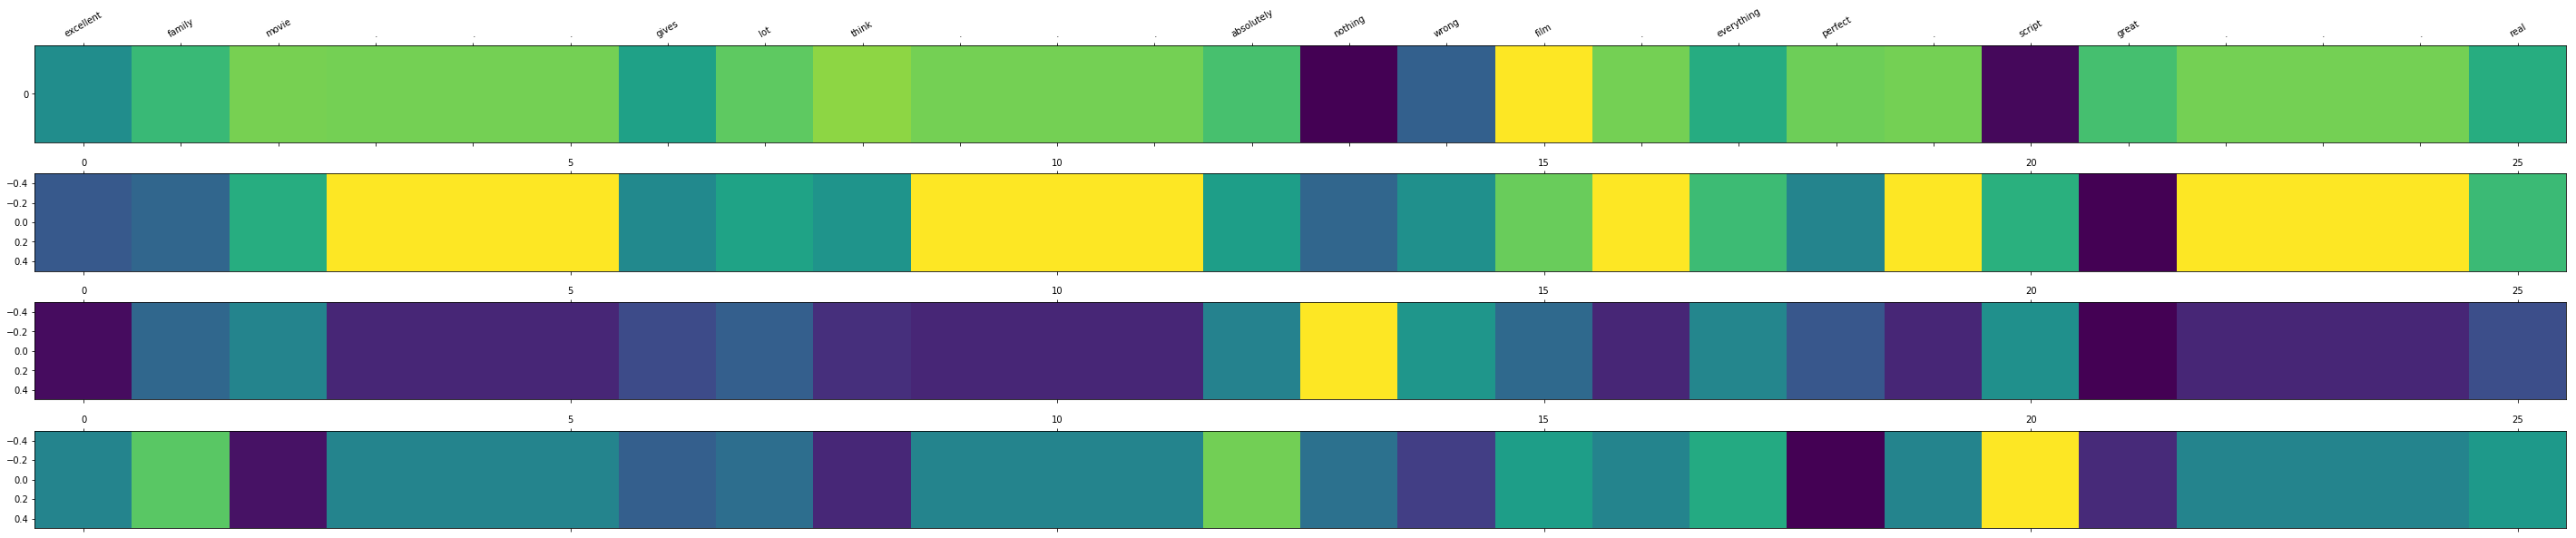

In [96]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    # ax.set_yticklabels([''] + sentence)
    ax.set_xticklabels([''] + sentence, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
little: 0.039756886661052704
movie: 0.03956252336502075
.: 0.03954581916332245
.: 0.03954581916332245
.: 0.03954581916332245

Least Attent Words:
----------Attention 1-----------
obvious: 0.037470802664756775
straight: 0.037840139120817184
hopefully: 0.037887413054704666
shot: 0.03794993832707405
screen: 0.037984058260917664

Most Attent Words:
----------Attention 2-----------
bad: 0.04232918471097946
bad: 0.04232918471097946
trying: 0.03893851488828659
big: 0.03888688236474991
seriously: 0.03886038064956665

Least Attent Words:
----------Attention 3-----------
screen: 0.03777046501636505
movie: 0.03788336366415024
trying: 0.03798460215330124
big: 0.03815180063247681
straight: 0.03820373862981796


Predicted Value: 0.06 True Value: 0.00
Weights: 0.9818976521492004, -1.6430469751358032


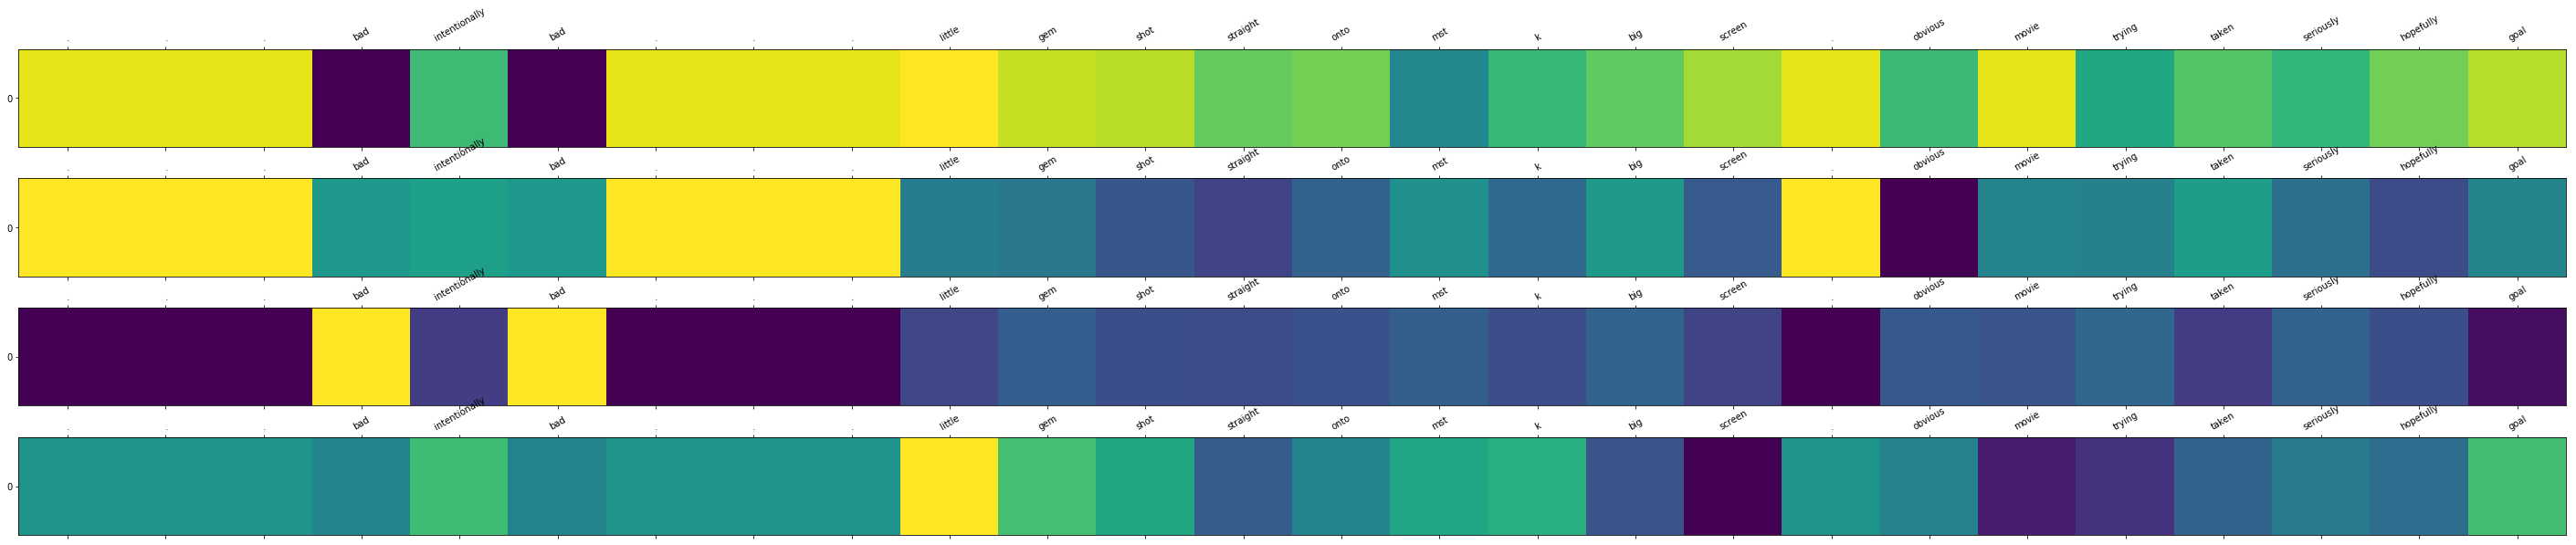

In [97]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    # ax.set_yticklabels([''] + sentence)
    ax.set_xticklabels([''] + sentence, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
soooo: 0.04050488770008087
good: 0.040395427495241165
character: 0.03963807225227356
quite: 0.039542533457279205
.: 0.039284393191337585

Least Attent Words:
----------Attention 1-----------
character: 0.037718359380960464
type: 0.0378122515976429
strange: 0.03784405067563057
give: 0.037909481674432755
movies: 0.037921056151390076

Most Attent Words:
----------Attention 2-----------
bad: 0.04244469851255417
poorly: 0.04057671129703522
acting: 0.03958044946193695
usually: 0.03942319378256798
something: 0.039198264479637146

Least Attent Words:
----------Attention 3-----------
strange: 0.037201281636953354
give: 0.03778087720274925
quite: 0.0378357358276844
character: 0.03791451454162598
movies: 0.038061242550611496


Predicted Value: 0.20 True Value: 0.00
Weights: 0.9818976521492004, -1.6430469751358032


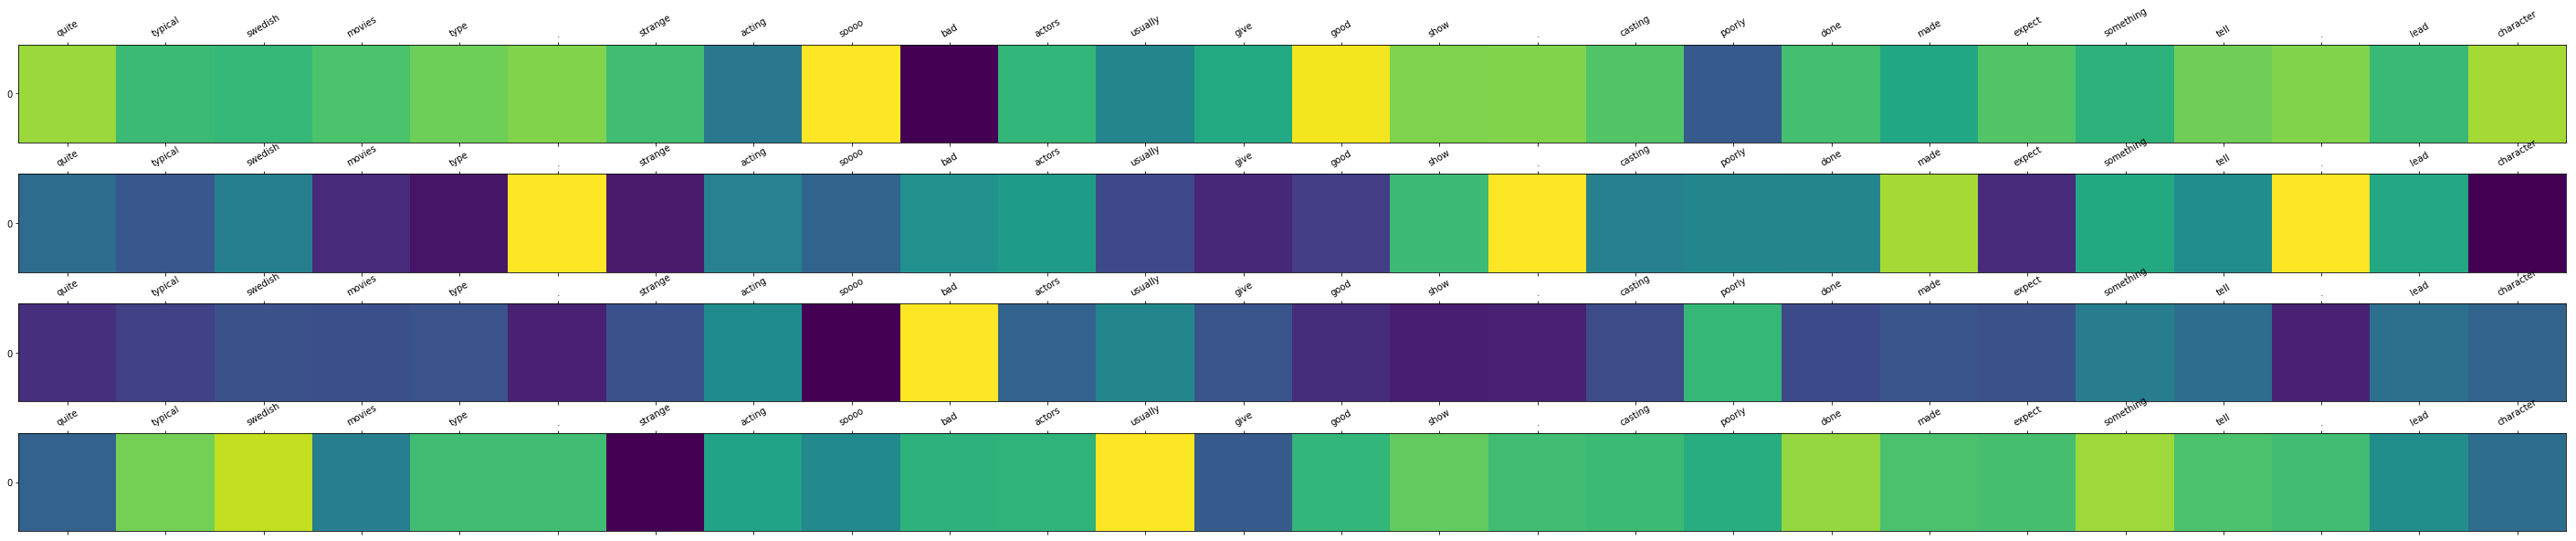

In [98]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    # ax.set_yticklabels([''] + sentence)
    ax.set_xticklabels([''] + sentence, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
film: 0.04013557359576225
best: 0.03978171944618225
best: 0.03978171944618225
one: 0.03941481187939644
one: 0.03941481187939644

Least Attent Words:
----------Attention 1-----------
works: 0.03759140521287918
class: 0.037617843598127365
many: 0.03790910914540291
levels: 0.03803730756044388
best: 0.03805774077773094

Most Attent Words:
----------Attention 2-----------
acting: 0.039810795336961746
script: 0.03910655528306961
completely: 0.03906887024641037
direction: 0.03900710865855217
films: 0.03888643905520439

Least Attent Words:
----------Attention 3-----------
class: 0.036981500685214996
direction: 0.03779517114162445
ever: 0.03811221197247505
ever: 0.03811221197247505
acting: 0.03813585266470909


Predicted Value: 0.73 True Value: 1.00
Weights: 0.9818976521492004, -1.6430469751358032


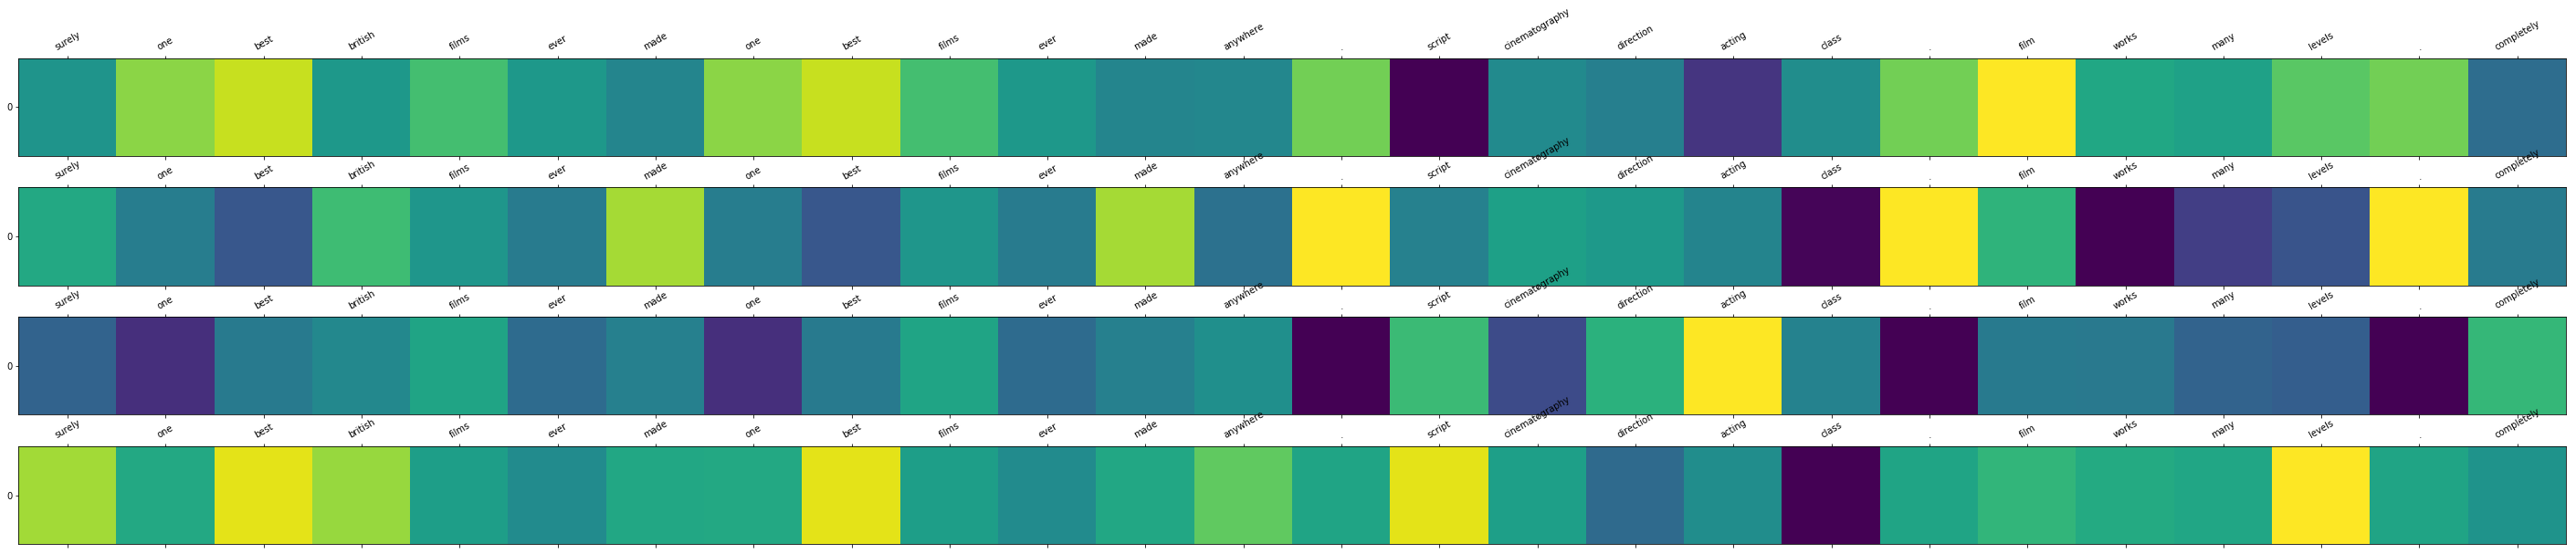

In [99]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    # ax.set_yticklabels([''] + sentence)
    ax.set_xticklabels([''] + sentence, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

Most Attent Words:
----------Attention 0-----------
videostore: 0.039860714226961136
good: 0.03975299373269081
film: 0.03953889384865761
film: 0.03953889384865761
little: 0.03886596858501434

Least Attent Words:
----------Attention 1-----------
die: 0.03720071166753769
boys: 0.037465307861566544
cheesy: 0.03760728985071182
local: 0.037969332188367844
good: 0.0380258746445179

Most Attent Words:
----------Attention 2-----------
enough: 0.039353467524051666
die: 0.03925280272960663
vampire: 0.03915977478027344
vein: 0.03909222409129143
expected: 0.03909164294600487

Least Attent Words:
----------Attention 3-----------
die: 0.0373036190867424
american: 0.03781789913773537
vein: 0.03791145607829094
movie: 0.0379725843667984
boys: 0.03802281990647316


Predicted Value: 0.84 True Value: 1.00
Weights: 0.9818976521492004, -1.6430469751358032


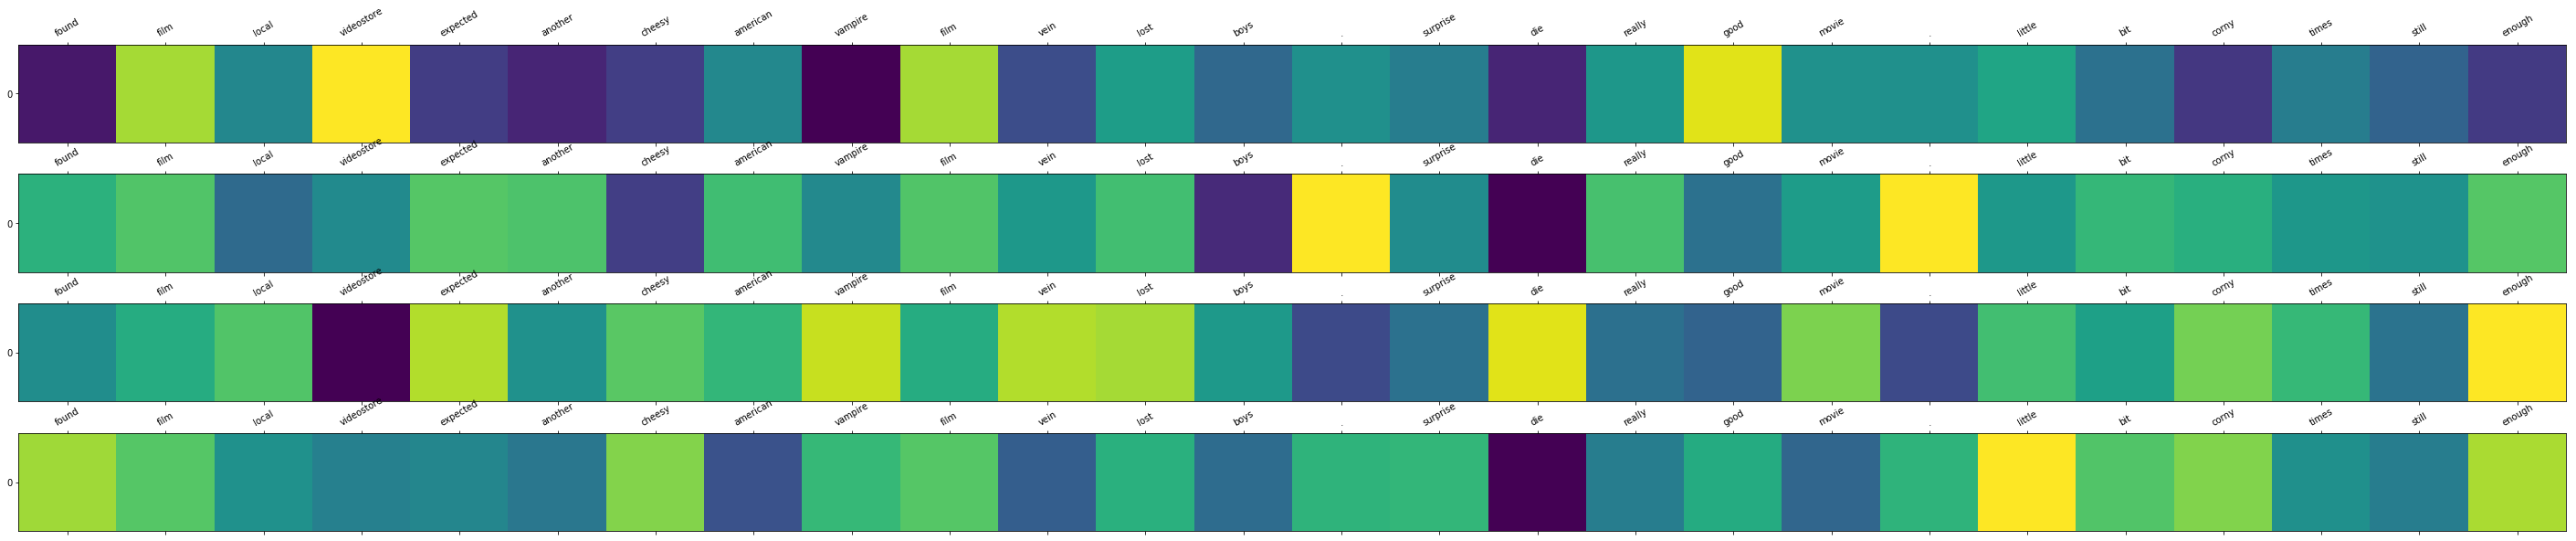

In [102]:
# attn = batch_attn[i][np.newaxis, ...]
sentence = sents[i]
y = targets[i]

fig, axs = plt.subplots(len(tracked_attention_weigths), 1, figsize=(50, 10))

for a, (ax, attn) in enumerate(zip(axs.flatten(), tracked_attention_weigths)):
    attn = attn.transpose(0, 1).detach().numpy().squeeze()[i][np.newaxis, ...]
    ax.matshow(attn, cmap='viridis')
    # ax.set_yticklabels([''] + sentence)
    ax.set_xticklabels([''] + sentence, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    attn = attn.squeeze()
    if a % 2 == 0:
        print("Most Attent Words:")
        idx = (-attn).argsort()[:n]
    else:
        print("Least Attent Words:")
        idx = attn.argsort()[:n]
        
    words = ["{}: {}".format(sentence[i], attn[i]) for i in idx]
    print('----------Attention {}-----------'.format(a))
    print('\n'.join(words))
    print()
    
print()
plt.plot()
print("Predicted Value: %.2f True Value: %.2f" % (pred_y[i], y))
print("Weights: {}, {}".format(model.weight1.detach().numpy().squeeze(), model.weight2.detach().numpy().squeeze()))
i += 1

In [110]:
attn = tracked_attention_weigths[0][4].squeeze()
torch.mean(attn), torch.var(attn)

(tensor(0.0385, grad_fn=<MeanBackward0>),
 tensor(1.0146e-06, grad_fn=<VarBackward0>))

In [ ]:
# 3 layer attention name
3june-1719-withta-3layer